<div style="color:white; background-color:#354538; border: 1px solid #FFE0C3; border-radius: 10px; margin-bottom:1rem">
    <p style="margin:1rem; padding-left: 1rem; line-height: 2.5;">
        ©️ <b><i>Copyright 2023 @ Authors</i></b><br/>
        作者：<a style="font-weight:bold" href="qhyu@std.suda.edu.cn">于清涵 📨 </a><br>
        日期：2023-11-03<br/>
        <a style="font-weight:bold" href="https://github.com/MDAnalysis/MDAnalysisWorkshop2023/blob/main/MD/MD_02_Distances_Trajectories.ipynb">MDAnalysis 参考资料：MDAnalysisWorkshop2023/MD/MD_02_Distances_Trajectories.ipynb </i><br/>
        <a style="font-weight:bold" href="http://wiki.cheng-group.net/wiki/software_usage/MDAnalysis/">Or see Wiki of prof. Cheng Group</i><br/>
</div>

In [1]:
import MDAnalysis as mda
from MDAnalysis.lib.distances import calc_angles, distance_array, capped_distance
from MDAnalysis.analysis.msd import EinsteinMSD
from MDAnalysis.analysis.rdf import InterRDF
from MDAnalysis.analysis.density import DensityAnalysis
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
from MDAnalysis.lib.log import ProgressBar


from ase.io import read,write
from ase.build import sort
from ase.visualize import view

from ovito.io import import_file, export_file
from ovito.data import *
from ovito.modifiers import ComputePropertyModifier,CalculateDisplacementsModifier, ExpressionSelectionModifier,CoordinationAnalysisModifier,TimeAveragingModifier,HistogramModifier,SelectTypeModifier

import os
import json
import warnings
# import numba  # need numpy 1.24 or less
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import splrep, splev, griddata
from tqdm import tqdm
from copy import deepcopy
from glob import glob
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')
# print("Using MDAnalysis version", mda.__version__)

e:\Project\pywork\ASE\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Configuration analysis

## 1.1 Angle

In [14]:
# Except use myself code, You can also use MDanalysis self model AngularDistribution to analysis, see https://www.osgeo.cn/mdanalysis/documentation_pages/analysis/waterdynamics.html#MDAnalysis.analysis.waterdynamics.AngularDistribution

def cal_angle(u, frame_freq=16000, O_H_cut_distance=1.2, O_start_index=31, H_start_index=63, min_deg=80):
    """ this function is used to calculate angle between H-O-H in water, return two list [angle_hoh] and [distance_O_H]"""
    print(u)
    # ag = u.atoms                                # all atoms as a atoms group
    # u.dimensions                                # box size 
    # xyz = ag.positions                          # coordinates for these atoms
    # elements = ag.elements                      # element labels for these atoms
    # n_frames = u.trajectory.n_frames            # get the number of frames of your traj
    # u.trajectory.ts.dt = 0.0005                 # set dt to 0.0005 ps,ts means timestep(like n frame)
    hydrogens = u.select_atoms('type 3')        # type 1 H
    oxygens = u.select_atoms('type 5')          # type 2 O
    assert len(hydrogens) == 2 * len(oxygens)   # check each water have 2 H per O

    angle_hoh, distance_O_H = [], []
    for ts in tqdm(u.trajectory):                # read every frame of MD traj
        if ts.frame % frame_freq == 0:
            angle_hoh_frame, distance_O_H_frame = [], []
            distances = distance_array(oxygens.positions, hydrogens.positions, box=u.dimensions,backend='OpenMP')    # calculation distance between all O and all H
            atom_O_neigh_lists = distances < O_H_cut_distance    #build neighbor list of atom type O (o with H),截断半径 1 埃
            for index_O, each_atom_O_neigh_list in enumerate(atom_O_neigh_lists):           
                each_atom_O_neigh_list_with_H = [index_H for index_H, atom_H in enumerate(each_atom_O_neigh_list) if atom_H]    # This is direct neighbor list, use it to calculate distance and angle
                H_indexs_of_each_O = [x + H_start_index for x in each_atom_O_neigh_list_with_H]
                index_O = index_O + O_start_index
                if len(H_indexs_of_each_O) == 2:
                    h1 =u.atoms[H_indexs_of_each_O[0]].position
                    o = u.atoms[index_O].position
                    h2 = u.atoms[H_indexs_of_each_O[1]].position
                    angle_rad = calc_angles(h1, o, h2)
                    angle_deg = np.rad2deg(angle_rad)
                    if angle_deg < min_deg:
                        pass
                    else:
                        angle_hoh_frame.append(angle_deg)
                    distance_each_O_with_H1 = distance_array(o, h1, box=u.dimensions,backend='OpenMP')
                    distance_each_O_with_H2 = distance_array(o, h2, box=u.dimensions,backend='OpenMP')
                    distance_O_H_frame.extend([distance_each_O_with_H1.tolist()[0][0], distance_each_O_with_H2.tolist()[0][0]])
            angle_hoh.append(angle_hoh_frame)
            distance_O_H.append(distance_O_H_frame)
    return angle_hoh, distance_O_H

def plt_angle_distribute(angle_hoh):
    plt.hist(angle_hoh, bins=10, alpha=0.5, density=True)

    angle_hoh_flat = np.concatenate(angle_hoh)
    mu, std = norm.fit(angle_hoh_flat)   # estimate mean and standard deviation
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)        # Gaussian distribution function
    plt.plot(x, p, 'k', linewidth=2)
    plt.xlabel('angle (degree)')
    plt.ylabel('Frequency')
    plt.title('H-O-H Angle Distribution')
    plt.show()

In [ ]:
u = mda.Universe(f'../activate-learning/iter05/model-0-compress-withMetaD-10ns/Fe-C-N4-sol-OH-new.data', f'../activate-learning/iter05/model-0-compress-withMetaD-10ns/dump_stage1.xyz', format='LAMMPSDUMP', atom_style='id type x y z')
angle_hoh, distance_O_H = cal_angle(u, frame_freq=16000, O_H_cut_distance=1.2)

# write angle_hoh to json file
json_file_name_ang = 'angle_hoh.json'
json_str = json.dumps(angle_hoh, indent=4)   #indent=4 means the indent of each line is 4 spaces
with open(json_file_name_ang, "w") as f:
    f.write(json_str)

# write distance_O_H to json file
json_file_name_dis = 'distance_O_H.json'
json_str = json.dumps(distance_O_H, indent=4)   #indent=4 means the indent of each line is 4 spaces
with open(json_file_name_dis, "w") as f:
    f.write(json_str)


json_file_name_ang = 'angle_hoh.json'
json_file_name_dis = 'distance_O_H.json'
with open(json_file_name_ang, 'r') as f:
    angle_hoh = json.load(f)
# plt_angle_distribute(angle_hoh)
angle_hoh_1D = np.concatenate(angle_hoh)
plt.plot(angle_hoh_1D)

with open(json_file_name_dis, 'r') as f:
    distance_O_H = json.load(f)
# plt_angle_distribute(distance_O_H)
distance_O_H_1D = np.concatenate(distance_O_H)
# plt.scatter(range(len(distance_O_H_1D)), distance_O_H_1D)
# plt.show()
# print(f'ave of distance_O_H_1D is {sum(distance_O_H_1D)/len(distance_O_H_1D)}')

## 1.2 Distance

## 1.3 Hydrogen bond

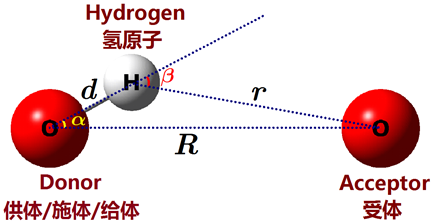

### 1.3.1 Calculation of hydrogen bond by MDanalysis

In [18]:
pre_dir = '../activate-learning/iter11/DPGen-6-model-0-with-CV10_MetaD-1000ps(height-0.05_O1_H-O1-Fe_wall-O1H-2.2_wall-d-FeO1_wall-cell.z)--反应角度-后半段/'                               # 后半
hydrogens = 'type 3'; o_atoms_in_waters = 'type 5 and not (id 56)' ; oxygen = 'id 56'
# pre_dir = '../activate-learning/iter11/DPGen-2-model-0-with-CV10_MetaD-1000ps(height-0.05_O2_H-O1-O2_wall-O2H-2.2_wall-O1H-0.2_wall-d-FeO1_wall-O1-O2_wall-cell.z)--before/'       # 前半    
# hydrogens = 'type 3'; o_atoms_in_waters = 'type 5 and not (id 62:63)' ; oxygen = 'id 63'
u = mda.Universe(pre_dir+'end-stage-end.data', pre_dir+'dump_stage1.xyz', format='LAMMPSDUMP', atom_style='id type x y z')                                                                 # 加载traj


""" pre_dir = '../activate-learning/iter10/model-0-with-CV10_MetaD-2000ps(height-0.05_d_O12_Fe_wall-O2H-0.2_wall-O1H-0.2_wall-d-FeO1_wall-d-FeO2_wall-O1-O2)-模拟O2吸附于位点-增加采样时间--※用于label/'
u = mda.Universe(pre_dir+'end-stage-end.data', pre_dir+'dump_stage1.xyz', format='LAMMPSDUMP', atom_style='id type x y z')
hydrogens = 'type 3'; o_atoms_in_waters = 'type 5 and not (id 62:63)'; oxygen = 'id 62:63'; water_O_around_O2 = 'type 5 and (around 4 id 62:63)'; Fe_N4_C = 'id 1:31'; Fe = 'type 2'
# oxygen_within_25_Fe = u.select_atoms('(id 62:63) and (around 3.6  type 2)',updating=True)
# oxygen_within_20_Fe = u.select_atoms('(id 62:63) and (around 3.4 type 2)',updating=True)
# oxygen_d_Fe_20_25 = oxygen_within_25_Fe - oxygen_within_20_Fe """

hbonds = HBA(universe=u, donors_sel=o_atoms_in_waters, hydrogens_sel=hydrogens, acceptors_sel=oxygen, d_h_cutoff=1.0, d_a_cutoff=3.0, d_h_a_angle_cutoff=160)  # d_h_cutoff=1.2(d in figure), d_a_cutoff=3(R in figure), d_h_a_angle_cutoff=150(180-β in figure)
hbonds.run(verbose=True)
print(hbonds.results.hbonds[0]) # return [frame, donor_index, hydrogen_index, acceptor_index, DA_distance, DHA_angle]

100%|██████████| 40001/40001 [01:21<00:00, 492.88it/s]

[  7.          49.         105.          55.           2.85583427
 171.08278651]


### 1.3.2 Analysis results of hydrogen bond by MDanalysis

sum = 13038


" # 其他联合求解输出, 求Fe-O2距离\noxygen = u.select_atoms('id 62:63'); Fe = u.select_atoms('type 2')\nframe_dis = [(ts.frame, distance_array(Fe[0].position, oxygen.center_of_mass())[0][0]) for ts in tqdm(u.trajectory)]\nnp.savetxt(pre_dir+'Distance of Fe-O2.txt', np.array(frame_dis), fmt=['%d','%.4f']) "

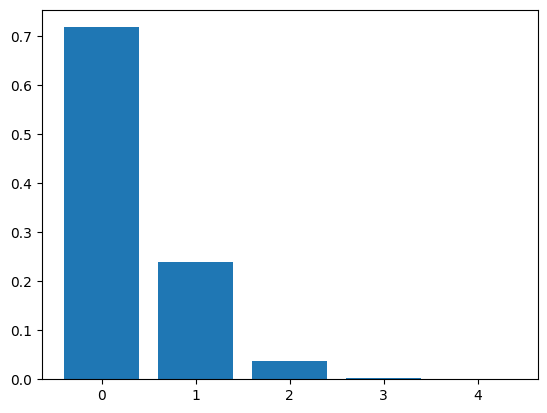

In [19]:
""" tau_timeseries, timeseries = hbonds.lifetime(tau_max=50)      # here, tau_timeseries is τ, which based on frame in trajs
np.savetxt(pre_dir+'Lifetime of H Bonds.txt', np.array([tau_timeseries, timeseries]).T, fmt='%.4f')
print(f'tau_timeseries: {tau_timeseries}, timeseries: {timeseries}')
plt.plot(tau_timeseries*25, timeseries, '-', markersize=4)      # here, 25 is the time(fs) between each frame in trajs """

""" h_ids  = hbonds.count_by_ids()
h_ids = h_ids[h_ids[:,3].argsort()]
print(f'h_ids: {h_ids}')
np.savetxt(pre_dir+'h_ids.txt', h_ids, fmt='%dcom') """

""" h_type = hbonds.count_by_type() 
print(f'h_type: {h_type}') """

h_time = hbonds.count_by_time()
# np.savetxt(pre_dir+'Number of H Bonds.txt', np.array([range(len(h_time)), h_time]).T, fmt='%d')
# print(f'h_time: {h_time}')
def probability_cal(hbond):
    counts = np.bincount(hbond)
    frame = len(hbond)
    probability = counts/frame
    print(f'sum = {sum(h_time)}')       # 前半/后半 12979/13038
    # pd.DataFrame.from_dict({'numbers of H bonds':range(len(counts)), 'probability':probability}).to_excel(pre_dir+'Number of H Bonds.xlsx', index=False)
    np.savetxt(pre_dir+'Number of H Bonds-probability.txt', np.array([range(len(counts)), probability]).T, fmt='%.4f')
    return counts, probability
# plt.scatter(hbonds.times, h_time, s=0.01)
counts, probability = probability_cal(h_time)
plt.bar(range(len(counts)), probability)
plt.xticks(range(len(counts)), labels=range(len(counts)))


""" # 其他联合求解输出, 求Fe-O2距离
oxygen = u.select_atoms('id 62:63'); Fe = u.select_atoms('type 2')
frame_dis = [(ts.frame, distance_array(Fe[0].position, oxygen.center_of_mass())[0][0]) for ts in tqdm(u.trajectory)]
np.savetxt(pre_dir+'Distance of Fe-O2.txt', np.array(frame_dis), fmt=['%d','%.4f']) """

In [ ]:
#===========Number of hydrogen bonds as a function of height in z===========

# bins in z for the histogram
bin_edges = np.linspace(-2, 19, 22)
bin_centers = bin_edges[:-1] + 0.5

# results array (this is faster and more memory efficient than appending to a list)
counts = np.full(bin_centers.size, fill_value=0.0)
for frame, donor_ix, *_ in hbonds.results.hbonds:

    u.trajectory[frame.astype(int)]
    donor = u.atoms[donor_ix.astype(int)]

    zpos = donor.position[2]
    hist, *_ = np.histogram(zpos, bins=bin_edges)   # hist is the counts(Hbond count) of each bin, while bin is based on bin_edges
    counts += hist * 2  # multiply by two as each hydrogen bond involves two water molecules

counts /= hbonds.n_frames   # average on all frames

plt.plot(bin_centers, counts, lw=2)

plt.title(r"Number of hydrogen bonds as a funcion of height in $z$", weight="bold")
plt.xlabel(r"$z\ \rm (\AA)$")
plt.ylabel(r"$N_{HB}$")

plt.show()

### 1.3.3 Number of Hydrogen bonds along the distance between O_2 and Fe

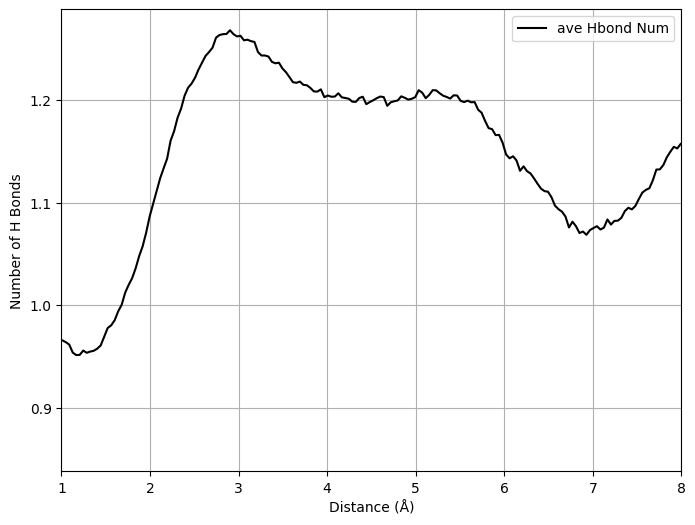

In [130]:
Num_Hbonds = np.loadtxt(pre_dir+'Number of H Bonds.txt')        # frame Num_Hbonds
dis_Fe_O2 = np.loadtxt(pre_dir+'Distance of Fe-O2.txt')         # frame dis_Fe_O2

dis_Num = []
for (dis, num) in zip(dis_Fe_O2, Num_Hbonds):
    dis_Num.append([dis[1], num[1]])
dis_Num = sorted(dis_Num, key = lambda x: x[0])                 # dis, count
dis_Num = np.array(dis_Num)

window_size = 200      # 1 ps/window
num_windows = len(dis_Num) // window_size
dis_range = max(dis_Num[:,0]) - min(dis_Num[:,0])
tau_dis = dis_range/num_windows
new_dis = [min(dis_Num[:,0]) + i * tau_dis for i in range(num_windows)]

average_hbond_per_window = []
for i in range(num_windows):
    start_idx = i * window_size
    end_idx = (i + 1) * window_size
    average_hbond_per_window.append(np.mean(dis_Num[start_idx:end_idx, 1]))

window_size_smooth = 25
average_hbond_per_window_smooth = np.convolve(average_hbond_per_window, np.ones(window_size_smooth), 'valid') / window_size_smooth
new_dis_smooth = new_dis[:len(average_hbond_per_window_smooth)]

plt.figure(figsize=(8, 6))
# plt.scatter(dis_Num[:,0], dis_Num[:,1], label='氢键数量')
plt.plot(new_dis_smooth, average_hbond_per_window_smooth, color='black', label='ave Hbond Num')
plt.xlabel('Distance (Å)')
plt.ylabel('Number of H Bonds')
plt.xlim(1,8)
plt.legend()
plt.grid(True)
plt.show()

np.savetxt(pre_dir+'Distance_Number_of_H_Bonds.txt', np.array([new_dis_smooth, average_hbond_per_window_smooth]).T, fmt='%.4f')

## 1.4 Water Dipole vector

In [25]:
# 有待修改

pre_dir = '../activate-learning/iter10/model-0-with-CV10_MetaD-2000ps(height-0.05_d_O12_Fe_wall-O2H-0.2_wall-O1H-0.2_wall-d-FeO1_wall-d-FeO2_wall-O1-O2)-模拟O2吸附于位点-增加采样时间--※用于label/'
u = mda.Universe(pre_dir+'end-stage-end.data', pre_dir+'dump_stage1.xyz', format='LAMMPSDUMP', atom_style='id type x y z')
# 选择你感兴趣的原子
hydrogens = u.select_atoms('type 3'); o_atoms_in_waters = u.select_atoms('type 5 and not (id 62:63)'); oxygen = u.select_atoms('id 62:63'); water_O_around_O2 = u.select_atoms('type 5 and (around 4 id 62:63)',updating=True); Fe_N4_C = u.select_atoms('id 1:31'); Fe = u.select_atoms('type 2')

""" # water-O2
pre_dir = '../activate-learning/iter10/water_60_5ps_DP_NVT_预弛豫/'
u = mda.Universe(pre_dir+'end-stage-end.data', pre_dir+'dump_stage1.xyz', format='LAMMPSDUMP', atom_style='id type x y z')
# 选择你感兴趣的原子
hydrogens = u.select_atoms('type 1'); o_atoms_in_waters = u.select_atoms('type 2') ; oxygen = u.select_atoms('id 20:21') """

""" pre_dir = 'E:/Project/Fe-C-N4/dataset/Initial-dataset/Fe-N4-C-sol-O2/0个H-fromMUST-同吸附water+O2--上传至data-inter-O2/'
u = mda.Universe(pre_dir+'entropy_use.xyz')
hydrogens = u.select_atoms('name H'); o_atoms_in_waters = u.select_atoms('name O and not (index 61:62)') ; oxygen = u.select_atoms('index 61:62') """

# 假设催化剂表面的法线是z轴
surface_normal = np.array([0, 0, 1])

# 初始化一个空的列表来存储角度
z_axis_list_8_12 = []; angles_8_12 = []; z_axis_list_12_16 = []; angles_12_16 = []; z_axis_list_16_20 = []; angles_16_20 = []; z_axis_list_20_24 = []; angles_20_24 = []
O_H_cut_distance = 1.2

aim_atoms_O = water_O_around_O2     # choice which O atoms to calculate the angle
for ts in tqdm(u.trajectory):
    pairs = capped_distance(aim_atoms_O, hydrogens, max_cutoff=O_H_cut_distance, box=u.dimensions, return_distances=False)
    atom_O_neigh_lists = [[] for _ in range(len(aim_atoms_O))]    # init neighbor list of atom type O (o with H)
    for pair in pairs:
        O_index, H_index = pair[0], pair[1]
        atom_O_neigh_lists[O_index].append(H_index)
    for index_O, each_atom_O_neigh_list_with_H in enumerate(atom_O_neigh_lists):
        # 根据点积的性质, COSɵ = (a·b) / (|a|*|b|)
        if len(each_atom_O_neigh_list_with_H) == 2:
            OH1_vector = hydrogens[each_atom_O_neigh_list_with_H[0]].position - aim_atoms_O[index_O].position
            OH2_vector = hydrogens[each_atom_O_neigh_list_with_H[1]].position - aim_atoms_O[index_O].position      # 计算O-H1和O-H2向量
            dipole_vector = OH1_vector + OH2_vector     # 计算偶极矩
            normal_vector = np.cross(OH1_vector, OH2_vector)  # water molecule normal vector 法向量
            dot_dipole_surface = np.dot(dipole_vector, surface_normal)
            dot_normal_surface = np.dot(normal_vector, surface_normal)
            norm2_dipole_surface = np.linalg.norm(dipole_vector) * np.linalg.norm(surface_normal)
            norm2_normal_surface = np.linalg.norm(normal_vector) * np.linalg.norm(surface_normal)
            angle_dipole_rad = np.arccos(dot_dipole_surface / norm2_dipole_surface) # arccos cosɵ-->ɵ计算偶极矩和催化剂表面法线之间的夹角
            angle_normal_rad = np.arccos(dot_normal_surface / norm2_normal_surface) # arccos cosɵ-->ɵ计算水分子法线和催化剂表面法线之间的夹角
            angle = np.rad2deg(angle_dipole_rad)
            # angle     = np.cos(angle_rad)   # 角度转化为余弦的统计

            dis_Fe_O2 = distance_array(Fe[0].position, oxygen.center_of_mass())[0][0]
            if dis_Fe_O2 > 2.1 and dis_Fe_O2 < 2.3:
                z_axis_list_8_12.append(dis_Fe_O2)
                angles_8_12.append(angle)
            elif dis_Fe_O2 > 3.4 and dis_Fe_O2 < 3.6:
                z_axis_list_12_16.append(dis_Fe_O2)
                angles_12_16.append(angle)
            elif dis_Fe_O2 > 6.35 and dis_Fe_O2 < 6.7:
                z_axis_list_16_20.append(dis_Fe_O2)
                angles_16_20.append(angle)

            """ z_coord = aim_atoms_O[index_O].position[2]
            
            z_Fe_N4_C = Fe_N4_C.center_of_mass()[2]
            z_Fe = Fe[0].position[2]
            if z_coord > 10 and z_coord < 14:        # For 2K atoms system, the z_coord of water in middum is between 8 and 22
                z_axis_list_8_12.append(z_coord)                   # 8-12 12-16 16-20 20-24
                angles_8_12.append(angle)
            elif z_coord > 14 and z_coord < 18:
                z_axis_list_12_16.append(z_coord)
                angles_12_16.append(angle)
            elif z_coord > 16 and z_coord < 20:
                z_axis_list_16_20.append(z_coord)
                angles_16_20.append(angle)
            elif z_coord > 20 and z_coord < 24:
                z_axis_list_20_24.append(z_coord)
                angles_20_24.append(angle) """
        else:
            pass

array_save = [np.array(list_tmp) for list_tmp in [z_axis_list_8_12, angles_8_12, z_axis_list_12_16, angles_12_16, z_axis_list_16_20, angles_16_20, z_axis_list_20_24, angles_20_24]]
np.savez(pre_dir+'z_axis_angles_lists.npz', *array_save)

100%|██████████| 80001/80001 [03:15<00:00, 409.04it/s]


sum_8: 1.0, sum_12: 0.9999999999999998, sum_16: 1.0


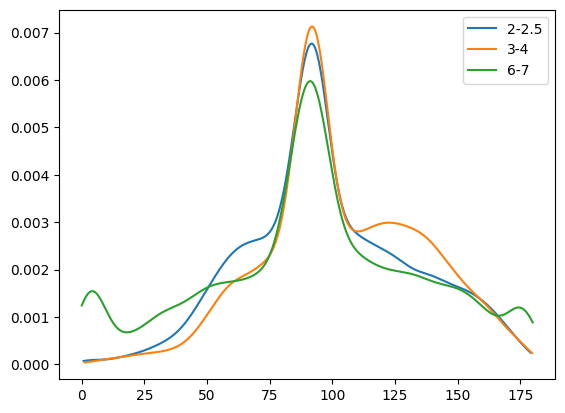

' x= z_axis_list_8_12; y = angles_8_12\nnum_intervals = 50  # 定义x的区间数\ninterval_width = (max(x) - min(x)) / num_intervals # 计算每个区间的宽度\ny_avg = [] # 初始化一个列表来存储每个区间的y值的平均值\nfor i in range(num_intervals):  # 对每个区间进行处理\n    # 计算区间的起始和结束值\n    start = min(x) + i * interval_width; end = start + interval_width\n    y_in_interval = [y[j] for j in range(len(x)) if start <= x[j] <\n      end]    # 找到在当前区间内的y值\n    y_avg.append(np.mean(y_in_interval))    # 计算这些y值的平均值，并添加到y_avg列表中\nx_intervals = np.linspace(min(x) + interval_width / 2, max(x) - interval_width / 2, num_intervals)  # 计算每个区间的中心点，这将作为绘图的x值\nplt.plot(x_intervals, y_avg) # 使用matplotlib绘制y_avg关于x_intervals的折线图 '

In [26]:
tmp_dict =  np.load(pre_dir+'z_axis_angles_lists.npz')
z_axis_list_8_12 = tmp_dict['arr_0']; angles_8_12 = tmp_dict['arr_1']; z_axis_list_12_16 = tmp_dict['arr_2']; angles_12_16 = tmp_dict['arr_3']; #z_axis_list_16_20 = tmp_dict['arr_4']; angles_16_20 = tmp_dict['arr_5']; angles_20_24 = tmp_dict['arr_7']
def kde_cal(angles,label):
    kde = gaussian_kde(angles)
    x = np.linspace(min(angles),max(angles),500)
    y = kde(x)
    pd.DataFrame.from_dict({'angle_'+label:x, 'distru'+label:y}).to_excel(pre_dir+'angles_'+label+'.xlsx', index=False)
    sum = np.sum(y)
    return x, y/sum   # normalization

x_8_12, y_8_12 = kde_cal(angles_8_12, label='8-12')
x_12_16, y_12_16 = kde_cal(angles_12_16, label='12-16')
x_16_20, y_16_20 = kde_cal(angles_16_20, label='16-20')
# x_20_24, y_20_24 = kde_cal(angles_20_24, label='20-24')

print(f'sum_8: {np.sum(y_8_12)}, sum_12: {np.sum(y_12_16)}, sum_16: {np.sum(y_16_20)}')
plt.plot(x_8_12,y_8_12, label='2-2.5')
plt.plot(x_12_16,y_12_16, label='3-4')
plt.plot(x_16_20,y_16_20, label='6-7')
# plt.plot(x_20_24,y_20_24, label='20-24')
plt.legend()
plt.show()


""" x= z_axis_list_8_12; y = angles_8_12
num_intervals = 50  # 定义x的区间数
interval_width = (max(x) - min(x)) / num_intervals # 计算每个区间的宽度
y_avg = [] # 初始化一个列表来存储每个区间的y值的平均值
for i in range(num_intervals):  # 对每个区间进行处理
    # 计算区间的起始和结束值
    start = min(x) + i * interval_width; end = start + interval_width
    y_in_interval = [y[j] for j in range(len(x)) if start <= x[j] <
      end]    # 找到在当前区间内的y值
    y_avg.append(np.mean(y_in_interval))    # 计算这些y值的平均值，并添加到y_avg列表中
x_intervals = np.linspace(min(x) + interval_width / 2, max(x) - interval_width / 2, num_intervals)  # 计算每个区间的中心点，这将作为绘图的x值
plt.plot(x_intervals, y_avg) # 使用matplotlib绘制y_avg关于x_intervals的折线图 """

# plt.scatter(z_axis_list_8_12, angles_8_12, s=0.01)
# plt.show()

# 2. MSD analysis

## 2.0 Reference result

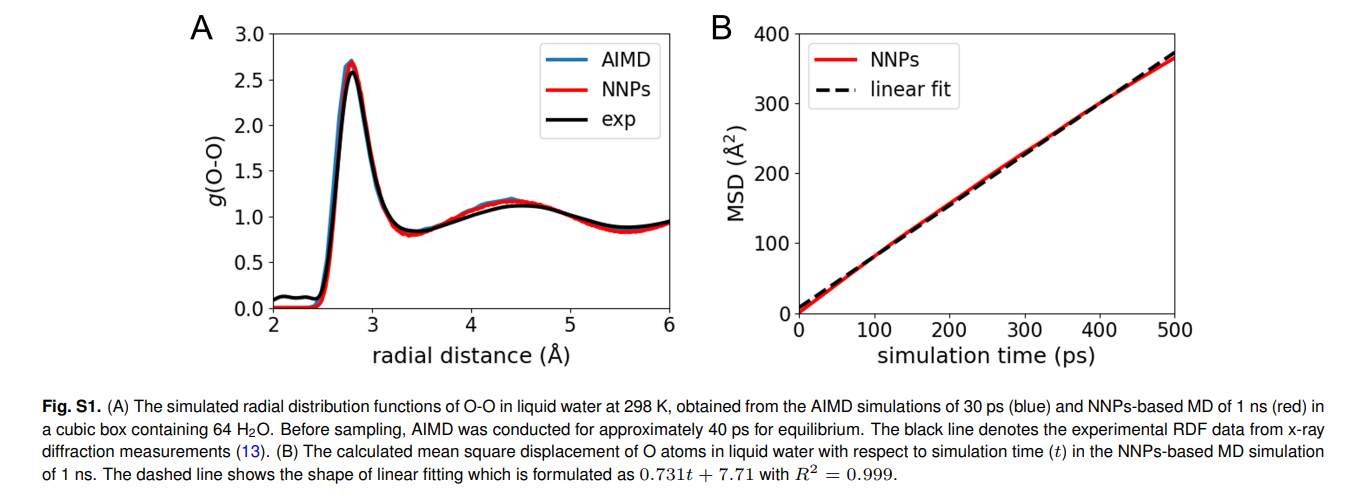
Mechanistic insights into water autoionization through metadynamics simulation enhanced by machine learning's Supporting Information

## 2.1 Cal by Dr. Li Pai's Code

### 2.1.1 Cal by python code

In [ ]:
""" # If data from LAMMPS dump file, you need use blow first:
atoms = read('./dump_stage1.xyz', index=":", format="lammps-dump-text", specorder=["H","O"])
# view(atoms[0])
# sort atoms
atoms = [sort(i) for i in atoms]
write('./XDATCAR', images=atoms, format='vasp-xdatcar', append=True) # 由于Atoms对象只能存单帧，因此本脚本atoms为列表，写为XDATCAR时候需要append添加 """

#================================================================================================#
# Generate XDATCAR.xyz and lattice.vectors from XDATCAR
xdatcar = open('XDATCAR', 'r')
xyz = open('XDATCAR.xyz', 'w')
xyz_fract = open('XDATCAR_fract.xyz', 'w')

system = xdatcar.readline()
scale = float(xdatcar.readline().rstrip('\n'))
print(scale)

#get lattice vectors
a1 = np.array([ float(s)*scale for s in xdatcar.readline().rstrip('\n').split() ])
a2 = np.array([ float(s)*scale for s in xdatcar.readline().rstrip('\n').split() ])
a3 = np.array([ float(s)*scale for s in xdatcar.readline().rstrip('\n').split() ])

print(a1)
print(a2)
print(a3)

#Save scaled lattice vectors
lat_rec = open('lattice.vectors', 'w')
lat_rec.write(str(a1[0])+' '+str(a1[1])+' '+str(a1[2])+'\n')
lat_rec.write(str(a2[0])+' '+str(a2[1])+' '+str(a2[2])+'\n')
lat_rec.write(str(a3[0])+' '+str(a3[1])+' '+str(a3[2]))
lat_rec.close()


#Read xdatcar
element_names = xdatcar.readline().rstrip('\n').split()

element_dict = {}
element_numbers = xdatcar.readline().rstrip('\n').split()

i = 0
N = 0
for t in range(len(element_names)):
    element_dict[element_names[t]] = int(element_numbers[i])
    N += int(element_numbers[i])
    i += 1

print(element_dict)

while True:
    line = xdatcar.readline()
    if len(line) == 0:
        break
    xyz.write(str(N) + "\ncomment\n")
    xyz_fract.write(str(N)+"\ncomment\n")
    for el in element_names:
        for i in range(element_dict[el]):
            p = xdatcar.readline().rstrip('\n').split()
            coords = np.array([ float(s) for s in p ])
#            print coords
            cartesian_coords = coords[0]*a1+coords[1]*a2+coords[2]*a3
            xyz.write(el+ " " + str(cartesian_coords[0])+ " " + str(cartesian_coords[1]) + " " + str(cartesian_coords[2]) +"\n")
            xyz_fract.write(el+ " " + str(coords[0])+ " " + str(coords[1]) + " " + str(coords[2]) +"\n")
xdatcar.close()
xyz.close()
xyz_fract.close()

In [ ]:
# This function reads an XYZ file and a list of lattice vectors L = [x,y,z] and gives MSD + unwrapped coordinates

def MSD(xyz_file,L):
    a = []; l = []
    a.append(L[0]); a.append(L[1]); a.append(L[2]); #basis vectors in cartesian coords
    l.append(np.sqrt(np.dot(a[0],a[0]))); l.append(np.sqrt(np.dot(a[1],a[1]))); l.append(np.sqrt(np.dot(a[2],a[2]))); #basis vector lengths

    file = open(xyz_file, 'r')
    recorder = open("msd.out", 'w')
    coord_rec = open("unwrapped.xyz", 'w')

    origin_list = [] # Stores the origin as [element,[coords]]
    prev_list = [] # Stores the wrapped previous step
    unwrapped_list = [] # Stores the instantenous unwrapped

    msd = [] #Stores atom-wise MSD  Stores msd as [msd]
    msd_dict ={} #Stores element-wise MSD
    msd_lattice = []
    msd_dict_lattice ={}

    element_list = [] # element list
    element_dict = {} # number of elements stored

    content = file.readline()   # read system atoms number in firstline 
    N = int(content)

    for i in range(N):      # initialize msd and msd_lattice
        msd.append(np.float64('0.0'))
        msd_lattice.append([0.0, 0.0, 0.0 ])

    file.readline()            # read and jump comment line
    step = 0

    while True:
        step += 1
        # Get and store the origin coordinates in origin_dict at first step
        if step == 1:
            for i in range(N):
                t = file.readline().rstrip('\n').split()    # read position line
                element = t[0]                              # first word is element
                if element not in element_list:
                    element_list.append(element)
                if element not in element_dict:
                    element_dict[element] = 1.0
                else:
                    element_dict[element] += 1.0
                coords = np.array( [ float(s) for s in t[1:] ] )
                origin_list.append([element,coords])
            # Copy the first set of coordinates as prev_dict and unwrapped
            unwrapped_list = deepcopy(origin_list)
            prev_list = deepcopy(origin_list)
            recorder.write("step ")                         # write the first line of msd.out
            for element in element_list:
                recorder.write(element+" ")
            recorder.write("\n")

        # Read wrapped coordinates into wrapped_dict
        content = file.readline()
        if len(content) == 0:
            print("\n---End of file---\n")
            break
        N = int(content)
        file.readline()
        wrapped_list = [] # Erease the previous set of coordinates（Reset）
        for i in range(N):
            t = file.readline().rstrip('\n').split()
            element = t[0]
            coords = np.array( [ float(s) for s in t[1:] ] )
            wrapped_list.append([element,coords])

        coord_rec.write(str(N)+ "\ncomment\n")      # write the 1st 2nd line of unwrapped.xyz

        # Unwrap coodinates and get MSD

        for atom in range(N):

            msd[atom] = 0.0

            coord_rec.write(wrapped_list[atom][0])  # write element to unwrapped.xyz

            # decompose wrapped atom coordinates to onto lattice vectors:
            w1 = wrapped_list[atom][1][0]
            w2 = wrapped_list[atom][1][1]
            w3 = wrapped_list[atom][1][2]

            # decompose prev atom coordinates to onto lattice vectors:
            p1 = prev_list[atom][1][0]
            p2 = prev_list[atom][1][1]
            p3 = prev_list[atom][1][2]

            #get distance between periodic images and use the smallest one
            if np.fabs(w1 - p1) > 0.5:                  # 默认两个时间步之间粒子移动小于0.5
                 u1 = w1 - p1 - np.sign(w1 - p1)    
            else:
                 u1 = w1 - p1

            if np.fabs(w2 - p2) > 0.5:
                 u2 = w2 - p2 - np.sign(w2 - p2)
            else:
                 u2 = w2 - p2

            if np.fabs(w3 - p3) > 0.5:
                 u3 = w3 - p3 - np.sign(w3 - p3)
            else:
                 u3 = w3 - p3

            #add unwrapped displacements to unwrapped coords

            unwrapped_list[atom][1][0] += u1        # a list, eg: [['el_1', [x1,y1,z1]], ['el_2', [x2,y2,z2]], ...]
            unwrapped_list[atom][1][1] += u2
            unwrapped_list[atom][1][2] += u3

            uw = unwrapped_list[atom][1][0]*a[0] + unwrapped_list[atom][1][1]*a[1] + unwrapped_list[atom][1][2]*a[2]
            ol =    origin_list[atom][1][0]*a[0] +    origin_list[atom][1][1]*a[1] +    origin_list[atom][1][2]*a[2]

            msd[atom] = np.linalg.norm(uw-ol)**2        # each atom has itself msd
            msd_lattice[atom] = [np.linalg.norm(uw[0]-ol[0])**2,np.linalg.norm(uw[1]-ol[1])**2,np.linalg.norm(uw[2]-ol[2])**2]

            coord_rec.write(" " + np.array_str(uw).replace("[","").replace("]","")) # write unwarp position to unwrapped.xyz
            coord_rec.write("\n")

        prev_list = [] # Store current wrapped coordinates for the next step
        prev_list = deepcopy(wrapped_list)
        # record msd
        recorder.write(str(step) + " ")     # write msd.out 

        for el in element_list:
             msd_dict[el] = 0.0     # a dict, eg: {'el_1':0, 'el_2':0}
             msd_dict_lattice[el]=[0.,0.,0.]

        for atom in range(len(msd)):                                                           # 相当于粒子数平均
            msd_dict[wrapped_list[atom][0]] += msd[atom]/element_dict[wrapped_list[atom][0]]   # 是哪个元素, 就加到哪个元素的msd上
            for i in range(3):
                msd_dict_lattice[wrapped_list[atom][0]][i] += msd_lattice[atom][i]/element_dict[wrapped_list[atom][0]]

        for el in element_list:
            recorder.write(str(msd_dict[el])+ " " + str(msd_dict_lattice[el][0])+ " " + str(msd_dict_lattice[el][1])+ " " + str(msd_dict_lattice[el][2])+ " ")

        recorder.write("\n")
        if step % 10 == 0:
            print(step)
    recorder.close()
    file.close()
    coord_rec.close()

def read_lat_vec():
    lat_file = open('lattice.vectors','r')
    line = []
    for i in range(3):
        line.append([float(x) for x in lat_file.readline().rstrip('\n').split()])
        print(line[i])
    lattice = np.array([line[0],line[1],line[2]])
    return lattice


#You can read the lattice vectors from lattice.vector file
lattice = read_lat_vec()

#Or define the lattice vector manually as in
#lattice =np.array([[-12.181156,-4.306689,7.459404],[0.000000,-12.920067,7.459404],[0.000000,0.000000,14.918808]])

#Run the MSD calculator with XDATCAR_fract.xyz and the lattice vector defined above
MSD("XDATCAR_fract.xyz",lattice)

### 2.1.2 Cal by fortran code(need make)

In [2]:
# If data from LAMMPS dump file, you need use blow first:
atoms = read("../activate-learning/iter10/water_640_500ps_DP_NVT_for_RDF-3-预先弛豫/dump_stage1.xyz", index=":", format="lammps-dump-text", specorder=["H","O"])
# view(atoms[0])
# sort atoms
atoms = [sort(i) for i in atoms]
write('../activate-learning/iter10/water_640_500ps_DP_NVT_for_RDF-3-预先弛豫/msd_cal/XDATCAR', images=atoms, format='vasp-xdatcar', append=True) # 由于Atoms对象只能存单帧，因此本脚本atoms为列表，写为XDATCAR时候需要append添加

#================================================================================================#
# Generate XDATCAR.xyz from XDATCAR
#lipai@mail.ustc.edu.cn

xdatcar = open('../activate-learning/iter10/water_640_500ps_DP_NVT_for_RDF-3-预先弛豫/msd_cal/XDATCAR', 'r')
xyz = open('../activate-learning/iter10/water_640_500ps_DP_NVT_for_RDF-3-预先弛豫/msd_cal/XDATCAR.xyz', 'w')

system = xdatcar.readline()
scale = float(xdatcar.readline().rstrip('\n'))
print(scale)

#get lattice vectors
a1 = np.array([ float(s)*scale for s in xdatcar.readline().rstrip('\n').split() ])
a2 = np.array([ float(s)*scale for s in xdatcar.readline().rstrip('\n').split() ])
a3 = np.array([ float(s)*scale for s in xdatcar.readline().rstrip('\n').split() ])

comment='Lattice=\"'+str(a1[0])+' '+str(a1[1])+' '+str(a1[2])
comment=comment+str(a2[0])+' '+str(a2[1])+' '+str(a2[2])
comment=comment+str(a3[0])+' '+str(a3[1])+' '+str(a3[2])+'\"'

#Read xdatcar
element_names = xdatcar.readline().rstrip('\n').split()

element_dict = {}
element_numbers = xdatcar.readline().rstrip('\n').split()

Natom = 0
Ntype = len(element_names)
Nname=[]
for t in range(Ntype):
    Natom += int(element_numbers[t])
    for i in range(int(element_numbers[t])):
        Nname.append(element_names[t])

print(Ntype,Natom)

f_prev=np.zeros([Natom,3])
f_next=np.zeros([Natom,3])
while True:
    line = xdatcar.readline()
    if len(line) == 0:
        break
    xyz.write(str(Natom) + "\n"+comment+"\n")

    for atom in range(Natom):
        p = xdatcar.readline().rstrip('\n').split()
        f_next[atom,:] = np.array([ float(s) for s in p ])
        f_next[atom,:] -= np.around(f_next[atom,:]-f_prev[atom,:])

        c_coords=f_next[atom,0]*a1+f_next[atom,1]*a2+f_next[atom,2]*a3
        xyz.write(Nname[atom]+" "+str(c_coords[0])+" "+str(c_coords[1])+" "+str(c_coords[2])+"\n")

    f_prev=deepcopy(f_next)

xdatcar.close()

xyz.close()

1.0
2 1920


In [ ]:
!lipai@mail.ustc.edu.cn
! user manual: ./cal_MSD_from_xyz.out XDATCAR.xyz n   n is the atom index you want cal msd; or 0 means all atoms
program xyz2msd
implicit none
integer :: ArgNum,i,j,k
character(len=20) :: filename,str1
integer :: Nind,AtomNum,FrameNum,Nline

real,dimension(3,3)::Lattice

real,dimension(:,:,:),allocatable :: xyz
real,dimension(:),allocatable   :: msd
real,dimension(:,:),allocatable :: msd_i
character(2) :: temp
integer :: stat1

ArgNum=command_argument_count()
if(ArgNum/=2) then
   write(*,*) "Wrong input argument!"
   stop
end if
call get_command_argument(1,filename)
filename=trim(adjustl(filename))
call get_command_argument(2,str1)
read(str1,*) Nind

open(unit=111,file=filename,status='old')

read(111,*) AtomNum
Nline=1
do
  read(111,*,iostat=stat1)
  Nline=Nline+1
  if(stat1/=0) exit
end do
FrameNum=Nline/(AtomNum+2)
write(*,*) AtomNum,FrameNum
allocate(xyz(FrameNum,AtomNum,3))

rewind(111)
do i=1,FrameNum
  read(111,*)
  read(111,*)
  do j=1,AtomNum
    read(111,*) temp, xyz(i,j,:)
  end do
end do
close(111)

allocate(msd(FrameNum),msd_i(FrameNum,3))
if(Nind==0) then
   call system("mkdir msd_all")
   do i=1,AtomNum
       call get_msd_ind(i,pre="msd_all/")
   end do
else
   if(Nind>AtomNum) then
       write(*,*) "Error! Nind>AtomNum"
       stop
   end if
   call get_msd_ind(Nind)
end if

contains
subroutine get_msd_ind(ind,pre)
implicit none
integer,intent(in) :: ind
character(*),optional,intent(in)  :: pre
character(20) :: outname
integer :: del_t,n,m,Fd
write(outname,*) ind
if(present(pre)) then
    outname=pre//trim(adjustl(outname))
else
    outname=trim(adjustl(outname))
end if
write(*,*) "Dealing with "//outname//".msd"
write(*,*) ind
msd=0
msd_i=0
do del_t=1,FrameNum-1
  Fd=FrameNum-del_t
  if(mod(del_t,100)==0) write(*,*) del_t
  do n=1,Fd
    do m=1,3
        msd_i(del_t,m)=msd_i(del_t,m)+((xyz(n+del_t,ind,m)-xyz(n,ind,m))**2)/Fd   ! MSD的时间平均: 系统任意时刻可以做位移起点, 根据Δt不同, 起点个数也不同. 
    end do                                                                        ! 将这些起点结合Δt计算的MSD, 对起点个数求平均, 即为时间平均后的MSD
    
  end do
  do m=1,3
      msd(del_t)=msd(del_t)+msd_i(del_t,m)
  end do
end do
open(99,file=trim(adjustl(outname))//".msd",status="replace")
open(98,file=trim(adjustl(outname))//".msd_i",status="replace")
do del_t=1,framenum-1
    write(99,*) msd(del_t)
    write(98,*) msd_i(del_t,:)
end do
close(99)
close(98)
end subroutine
end program

### 2.1.3 Plot

In [ ]:
# If use 2.1.1 python code cal MSD, you need :

""" data_MSD = pd.read_csv('../activate-learning/iter10/water_60_5ps_DP/msd_cal/msd.out', sep=" ", index_col=False)
# print(data_MSD['step'])
# data_MSD.plot(x='step', y=['msd_of_H', 'msd1_x', 'msd1_y', 'msd1_z', 'msd_of_O', 'msd2_x', 'msd2_y', 'msd2_z'])
data_MSD['step_ps'] = data_MSD['step'] * 5
# print(data_MSD)
data_MSD.plot(x='step_ps', y=['msd_of_O','msd2_x','msd2_y','msd2_z'])
plt.show() """

#=====================================================================================================#

# If use 2.1.2 fortran code cal MSD, you need :

folder_path = '../activate-learning/iter10/water_60_5ps_AIMD_NVT/AIMD_NVT_5ps结果/old-2/msd_cal/分段--每1ps计算一次msd_cal/msd_all_4'
# folder_path = '../activate-learning/iter10/water_60_5ps_DP_NVT_预弛豫/msd_cal/分段--每1ps计算一次msd/msd_all_4'
file_list = [f for f in os.listdir(folder_path) if f.endswith('.msd')]

data_list = []      # 先组成list, 再拼接
for file_name in file_list:
    file_path = os.path.join(folder_path, file_name)
    data = pd.read_csv(file_path, header=None)  # 假设没有列名，使用默认的列索引
    data_list.append(data)

data_MSD = pd.concat(data_list, axis=1)    # 列方向拼接
column_names = [f'atom{i+1}' for i in range(len(file_list))]
data_MSD.columns = column_names
data_MSD['step'] = data_MSD.index
data_MSD['step_ps'] = data_MSD['step'] * 5 /1000
# print(data_MSD)

sum_result = data_MSD.loc[:, 'atom121':'atom180'].sum(axis=1)     # 所有行（:）和名为 “atom1” 到 “atom180” 的列, 横向求和
ave_result = sum_result/640
data_MSD['ave'] = ave_result
# print(data_MSD)
data_MSD.plot(x='step_ps', y='ave')
plt.show()

""" # 不做粒子数平均, 展示单个粒子的MSD
data_MSD_i = pd.read_csv('../activate-learning/iter10/water_640_500ps_DP_NVT_for_RDF-3-预先弛豫/msd_cal/msd_all/1914.msd', index_col=False, header=None)
data_MSD_i['step'] = data_MSD_i.index
data_MSD_i.rename(columns={0: 'msd'},inplace=True)
# print(data_MSD_i)
data_MSD_i['step_ps'] = data_MSD_i['step'] * 25 /1000
data_MSD_i.plot(x='step_ps', y='msd')

plt.show() """

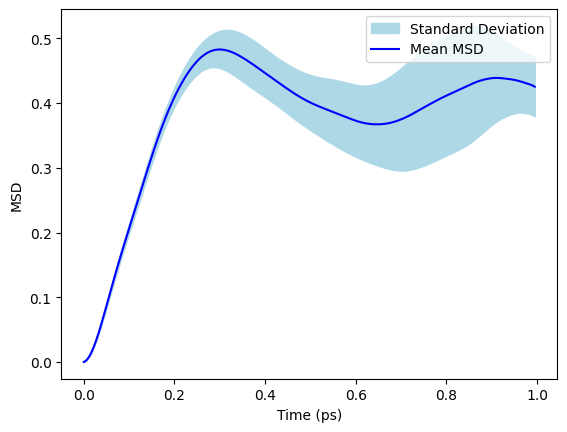

In [58]:
# If use 2.1.2 fortran code cal MSD, and you want cal MSD average, you need :
# 定义文件夹路径
# folder_paths = ['../activate-learning/iter10/water_60_5ps_AIMD_NVT/AIMD_NVT_5ps结果/old-2/msd_cal/分段--每1ps计算一次msd_cal/msd_all_{}'.format(i) for i in range(1,5)]
folder_paths = ['../activate-learning/iter10/water_60_5ps_DP_NVT_预弛豫/msd_cal/分段--每1ps计算一次msd/msd_all_{}'.format(i) for i in range(1, 5)]

# 指定原子范围
atom_start = 121
atom_end = 180
# 初始化数据列表
data_list = []; averages = []
# 遍历每个文件夹
for folder_path in folder_paths:
    file_list = [f for f in os.listdir(folder_path) if f.endswith('.msd') and int(f.split('.')[0]) in range(atom_start, atom_end+1)]
    
    temp_data_list = []
    
    # 读取每个文件夹中的文件
    for file_name in file_list:
        file_path = os.path.join(folder_path, file_name)
        data = pd.read_csv(file_path, header=None)
        temp_data_list.append(data)
    
    # 将当前文件夹的数据合并
    if temp_data_list:
        folder_data = pd.concat(temp_data_list, axis=1)
        sum_of_columns = folder_data.sum(axis=1)
        average = sum_of_columns/folder_data.shape[1]
        averages.append(average)
        data_list.append(folder_data)
        
""" # 所有iter的所有原子数据集合, 用于后续可能用到的处理:
data_MSD = pd.concat(data_list, axis=1)
column_names = [f'atom_{i+1}_{iter}' for iter in range(1,5) for i in range(len(file_list))]
data_MSD.columns = column_names """

# 所有iter的MSDaverage and standard deviation:
data_MSD_ave = pd.concat(averages, axis=1)
means = data_MSD_ave.mean(axis=1)
stds = data_MSD_ave.std(axis=1)
data_MSD_ave['mean'] = means
data_MSD_ave['std'] = stds

# 创建时间步长列
step_ps = data_MSD_ave.index * 2.5 / 1000
data_MSD_ave['step_ps'] = step_ps
data_MSD_ave.to_excel('../activate-learning/iter10/water_60_5ps_DP_NVT_预弛豫/msd_cal/分段--每1ps计算一次msd/MSD_ave_std.xlsx')

# 绘制MSD平均值和标准差
plt.fill_between(step_ps, means-stds, means+stds, color='lightblue', label='Standard Deviation')
plt.plot(step_ps, means, label='Mean MSD', color='blue')
plt.xlabel('Time (ps)')
plt.ylabel('MSD')
plt.legend()
plt.show()

The slope is 0.021134685708932937 and the intercept is 0.5268682456230654
The R² value is 0.9999207714065438


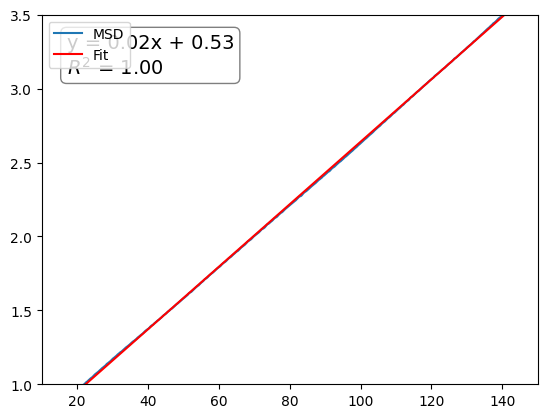

In [26]:
# 拟合
start_ps = 10
end_ps = 150
# 从数据中提取这个区间
fit_data = data_MSD[(data_MSD['step_ps'] >= start_ps) & (data_MSD['step_ps'] <= end_ps)]

# 使用numpy.polyfit进行线性拟合
coefficients = np.polyfit(fit_data['step_ps'], fit_data['ave'], 1)

# 输出拟合的斜率和截距
slope, intercept = coefficients
print(f"The slope is {slope} and the intercept is {intercept}")
# 计算拟合的y值
y_fit = np.polyval(coefficients, fit_data['step_ps'])
# 计算R²值
r2 = r2_score(fit_data['ave'], y_fit)
print(f"The R² value is {r2}")

# 在图上添加拟合线
plt.plot(data_MSD['step_ps'], data_MSD['ave'], label='MSD')
plt.plot(fit_data['step_ps'], slope*fit_data['step_ps'] + intercept, 'r', label='Fit')
plt.text(0.05, 0.95, f'y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r2:.2f}', transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.xlim(start_ps, end_ps)
plt.ylim(1.0, 3.5)
plt.legend()
plt.show()

## 2.2 Use ASE

[-8.229134616694038e-10]


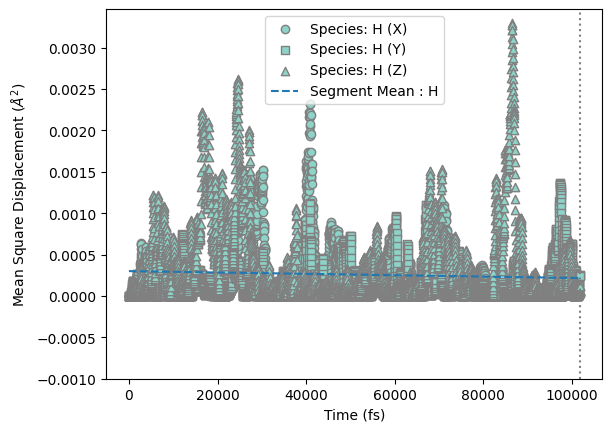

In [8]:
# use ASE to calculation MSD
from ase.io import read
from ase.md.analysis import DiffusionCoefficient
from ase.units import fs

# atoms = read('../activate-learning/iter10/water_140_500ps_for_RDF/dump_stage1.xyz', index=":", format="lammps-dump-text", specorder=["H","O"])
atoms = read('../activate-learning/iter10/water_60_5ps_AIMD/AIMD_5ps结果/old-2/vasprun.xml', index=":", format="vasp-xml")
diffusion = DiffusionCoefficient(atoms, timestep=2.5, atom_indices=[60])
diffusion.calculate()   # 计算diffusion coefficient
# diffusion.print_data()
ax_user = plt.gca()
# ax_user.x_lim = (0, 1)
diffusion.plot(ax=ax_user)

diffusion_coefficients, std = diffusion.get_diffusion_coefficients()
diffusion_coefficients_fs = [dc * fs for dc in diffusion_coefficients]
print(diffusion_coefficients_fs)   # 扩散系数 unit: Å^2/fs

## 2.3 Use Ovito

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


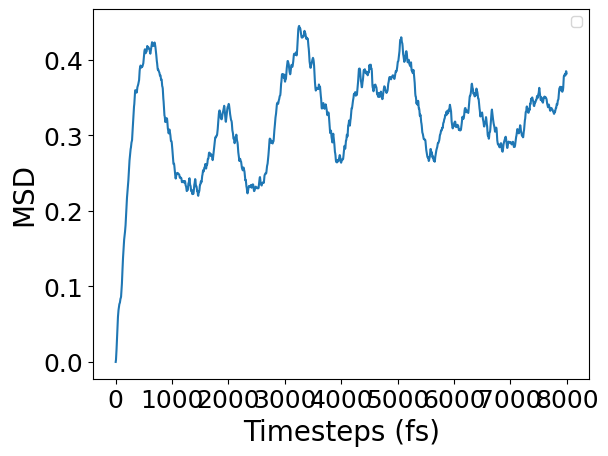

In [3]:
# 加载输入数据并创建数据管道
# pipeline = import_file("../activate-learning/iter10/water_O2_1000ps_for_MSD_lmp计算MSD_1ns采样/dump_stage1.xyz")
pre_dir = '../activate-learning/iter10/water_60_5ps_DP/'
pipeline = import_file(pre_dir + '/dump_stage1.xyz')


# 添加管道的修饰, 使用CalculateDisplacementsModifier计算每个粒子相对于第一帧的位移
pipeline.modifiers.append(CalculateDisplacementsModifier())     # CalculateDisplacementsModifier 是一种修饰器

# 选择特定类型原子
pipeline.modifiers.append(ExpressionSelectionModifier(expression='ParticleIdentifier==78 || ParticleIdentifier==87'))   # 选择特定原子

# 定义管道修正函数
def calculate_msd(frame,data):  # frame表示当前帧的帧号, data表示当前帧的数据
    # 访问由CalculateDisplacementsModifier计算的每个粒子的位移幅度, 并将结果存储在粒子属性'Displacement Magnitude'中
    displacement_magnitudes = data.particles['Displacement Magnitude']
    
    # 计算MSD
    msd = np.sum(displacement_magnitudes ** 2) / len(displacement_magnitudes)
    
    # 输出MSD值作为全局属性
    data.attributes["MSD"] = msd

# 将自定义修饰函数插入到数据管道中
pipeline.modifiers.append(calculate_msd)

# 将计算的MSD值导出到文本文件中
export_file(pipeline, pre_dir+"/msd_data.txt", format="txt/attr", columns=["Timestep", "MSD"], multiple_frames=True)

data = np.loadtxt(pre_dir+'/msd_data.txt')

x = data[:,0]       # timestep
y = data[:,1]     # MSD
plt.plot(x,y)
plt.xlabel('Timesteps (fs)',fontsize=20)
plt.ylabel('MSD',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# plt.ylim(-0.0,4)
# plt.xlim(0,8)
# plt.title('RDF of O-H and O-O')
plt.legend()
plt.show()


## 2.4 Cal by LAMMPS

<Axes: xlabel='step_ps'>

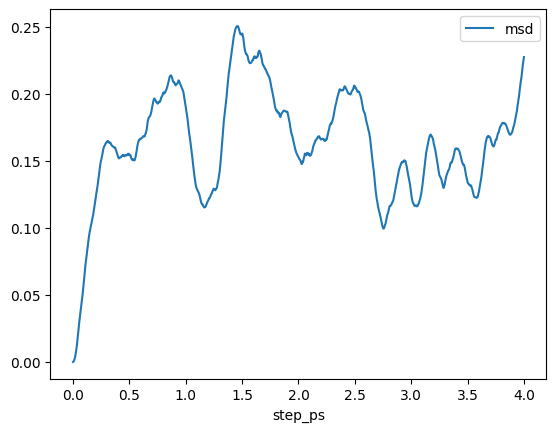

In [4]:
data = pd.read_csv('../activate-learning/iter10/water_60_5ps_DP/msd.dat', sep=' ')
data['step_ps'] = data['Step'] * 0.5 /1000
data.plot(x='step_ps', y='msd')

## 2.5 Use MDAnalysis

In [ ]:
# this code is under development
u = mda.Universe(f'../activate-learning\iter10\water_O2_1000ps_for_MSD_lmp计算MSD_1ns采样/water_O2.data', 
                 f'../activate-learning\iter10\water_O2_1000ps_for_MSD_lmp计算MSD_1ns采样/dump_stage1.xyz', format='LAMMPSDUMP', atom_style='id type x y z')
# u = mda.Universe(f'../activate-learning/iter10/water_60_5ps_AIMD/AIMD_5ps结果/old-2/traj_fix_1.xyz', 
#                  f'../activate-learning/iter10/water_60_5ps_AIMD/AIMD_5ps结果/old-2/traj_fix.xyz', format='XYZ', atom_style='type x y z')
u.trajectory.ts.dt = 0.0005 # 0.0005                 # set dt to 0.0005 ps,ts means timestep(like n frame)
# select atom type O
hydrogen = u.select_atoms('type 1')          # type 3 H
oxygens = u.select_atoms('type 2')           # type 5 O
# oxygen = u.select_atoms('id 78 or id 87')    # gas oxygen atoms index 62 63  select method: id 62:63; bynum 62:63; index 61:62; id 78 or id 87
# oxygen = u.select_atoms('id 1') 
# calculation MSD of O2
msd_O = EinsteinMSD(oxygens, msd_type='xyz', fft=True)       # use oxygen to calculate MSD of O2, use oxygens to calculate MSD of O atoms in water
msd_O.run(step=1, verbose=True) # start=3000,stop=17500,
nframes = msd_O.n_frames
timestep = 1    # same as step in run()
lag_times = np.arange(0,nframes) * timestep * 25 * 0.001  
                                            # 25
print(msd_O.ag)
plt.figure()
# plt.plot(msd_O.times, msd_O.results.timeseries,label='times')
# plt.plot(msd_O.frames, msd_O.results.timeseries,label='frames')
plt.plot(lag_times, msd_O.results.timeseries,label='lag_times')
# plt.plot(lag_times, 6*lag_times, label='6Dt')
plt.xlabel('Time (ps)')
plt.ylabel('MSD (Å^2)')
plt.legend()
plt.show()

""" from scipy.stats import linregress
start_time = 15000
start_index = int(start_time/timestep)
end_time = 20000
end_index = int(end_time/timestep)
linear_model = linregress(lag_times[start_index:end_index],msd_O.results.timeseries[start_index:end_index])
slope = linear_model.slope
error = linear_model.stderr
# dim_fac is 3 as we computed a 3D msd with 'xyz'
D = slope * 1/(2*msd_O.dim_fac)
print(f'D={D}') """

# 3. Density analysis and pH

## 3.1 Density

### 3.1.1 water Density of single structure and trajectory

In [2]:
def density_waters(water_nums=80,mass_pre_define=None,a=1,b=1,c=1,alpha=90,beta=90,gamma=90,if_hex=1):
    # calculation water density
    Na = 6.02214076e23                          # define Avogadro constant, mol^-1
    mol_mass_H2O = 18.01528                     # g/mol
    if mass_pre_define == None:
        mass = (water_nums * mol_mass_H2O) / Na     # g
    else:
        mass = mass_pre_define / Na
    if if_hex == 1:
        # volume = 11 * 13 * 16 * 1e-24         # cm^3
        # volume = 6 * 6  * 6 * 1e-24           # cm^3
        volume = a * b * c * 1e-24              # cm^3
    elif if_hex == 2:
        volume = a * (b*1.7321/2) * c * 1e-24   # cm^3
        # volume = 10.1 * (13.4*1.7321/2) * 8.5 * 1e-24
    elif if_hex == 3:
        alpha_r = np.deg2rad(alpha)             # 角度转换为弧度 degree to radian
        beta_r = np.deg2rad(beta)
        gamma_r = np.deg2rad(gamma)
        volume = a * b * c * np.sqrt(1 - np.cos(alpha_r)**2 - np.cos(beta_r)**2 - np.cos(gamma_r)**2 + 2 * np.cos(alpha_r) * np.cos(beta_r) * np.cos(gamma_r)) * 1e-24   # cm^3
    density = mass / volume                     # g/cm^3
    # print(f'mass of water_{water_nums} is {mass:.25f} g')
    return density

In [8]:
# a sample test of function density_waters
density_current_structure = density_waters(water_nums=64,a=11,b=13,c=16,alpha=90,beta=90,gamma=90,if_hex=3)
print(f'density of water_{12} is {density_current_structure:.6f} g/cm^3')

density of water_12 is 0.836785 g/cm^3


In [ ]:
# calculation density of waters of trajs 
u = mda.Universe(f'../activate-learning/iter10/water_O2_1000ps_for_MSD/water_O2.data', f'../activate-learning/iter10/water_O2_1000ps_for_MSD/dump_stage1.xyz', format='LAMMPSDUMP', atom_style='id type x y z')

print(u)
# cal mass from universe atoms type
atom_types = [atom.type for atom in u.atoms]
from collections import Counter
atom_types_count = Counter(atom_types)
mass_pre_define = atom_types_count['1'] * 1.0079 + atom_types_count['2'] * 15.9994              # 相对分子质量, type 1 H, type 2 O

density_trajs = []
for ts in tqdm(u.trajectory):                # read every frame of MD traj
        # print(ts)
        current_frame = u.trajectory.frame
        box_info = u.dimensions
        den_water_trajs = density_waters(mass_pre_define=mass_pre_define,a=box_info[0],b=box_info[1],c=(box_info[2]-5),alpha=box_info[3],beta=box_info[4],gamma=box_info[5],if_hex=3)
        density_trajs.append([current_frame, den_water_trajs])

density_trajs = np.array(density_trajs)
plt.plot(density_trajs[:,0]*50*0.5, density_trajs[:,1])         # 50 means export_dump/50_frame  0.5 means timesteps=0.5 fs
plt.xlabel('Time (fs)')

plt.ylabel('Water Density (g/cm^3)')
plt.show()

### 3.1.2 Z-axis water density with MDAnalysis 

In [153]:
# calculation density of element on the way of z
pre_dir = '../activate-learning/iter10/model-0-with-CV10_MetaD-2000ps(height-0.05_d_O12_Fe_wall-O2H-0.2_wall-O1H-0.2_wall-d-FeO1_wall-d-FeO2_wall-O1-O2)-模拟O2吸附于位点-增加采样时间--※用于label/'
u = mda.Universe(pre_dir+'end-stage-end.data', pre_dir+'dump_stage1.xyz', format='LAMMPSDUMP', atom_style='id type x y z')
hydrogens = u.select_atoms('type 3'); o_atoms_in_waters = u.select_atoms('type 5 and not (index 61:62)') ; oxygen = u.select_atoms('index 61:62'); Fe_N4_C = 'id 1:31'; Fe = 'type 2' 

# u.trajectory[10]                            # 计算指定帧的密度
D = DensityAnalysis(hydrogens, delta=0.1)   # delta means grid point distance        
D.run(verbose=True)

z_density = D.results.density.grid[:, :, :].mean(axis=(0, 1))       # D.results.density.grid 是一个三维数组，包含了每个网格点的密度. mean(axis=(0, 1) 即为对x和y方向积分,剩下自然为z方向密度
np.savetxt(pre_dir+'z-axis-density.txt', np.column_stack((D.results.density.edges[2][:-1], z_density)), delimiter='\t', fmt='%f', header="distance-z (Angstrom)\t density")    
# [[n_edges],[n_density]] ==> [[edge1, density1], [edge2, density2], ...]

plt.plot(D.results.density.edges[2][:-1], z_density)                # 通过切片来获取z方向上的密度分布
plt.xlabel('z')
plt.ylabel('Density (particles/Å³)')
plt.show()

area = np.trapz(z_density, D.results.density.edges[2][:-1])
print(area)

" plt.plot(D.results.density.edges[2][:-1], z_density)                # 通过切片来获取z方向上的密度分布\nplt.xlabel('z')\nplt.ylabel('Density (particles/Å³)')\nplt.show()\n\narea = np.trapz(z_density, D.results.density.edges[2][:-1])\nprint(area) "

### 3.1.3 Water density of Protein and CNTs

In [56]:
# pre_dir = 'K:\\BS2-PGs\\cheers\\160-0722\\'
pre_dir = 'K:\\BS2-PGs\\striped\\160-08292\\'
u = mda.Universe(pre_dir+'7.pdb', pre_dir+'md1-200.dcd', format='DCD')
# select_waters = u.select_atoms('resname TIP3 and (prop z > -43 and prop z < -15) and (prop x > -59.42 and prop x < 60.13) and (prop y > -63.969 and prop y < 65.4)', updating=True)        # cheers\\160-0722
# select_waters = u.select_atoms('resname TIP3 and (prop z > -35 and prop z < -32.5) and (prop x > -57.167 and prop x < 61.77) and (prop y > -63.59 and prop y < 65.87)', updating=True)      # striped\\160-08292
select_waters = u.select_atoms('resname TIP3 and (prop z > -26.15 and prop z < -22.15) and (prop x > -57.167 and prop x < 61.77) and (prop y > -63.59 and prop y < 65.87)', updating=True)      # striped\\160-08292
D = DensityAnalysis(select_waters, delta=0.2)
D.run(verbose=True)
# D.results.density.grid 是一个三维数组，包含了每个网格点的密度
# 你可以通过切片来获取z方向上的密度分布
# print(f'type of D is {type(D)}')
z_density = D.results.density.grid[:, :, :].mean(axis=(0, 1))
x_density = D.results.density.grid[:, :, :].mean(axis=(1, 2))
y_density = D.results.density.grid[:, :, :].mean(axis=(0, 2))
xy_density = D.results.density.grid[:, :, :].mean(axis=2)       # 只对z方向积分
# np.savetxt(pre_dir+"water-density.txt", np.column_stack((D.results.density.edges[2][:-1], z_density)), header="distance-z (Angstrom)\t density")

100%|██████████| 250/250 [00:43<00:00,  5.76it/s]


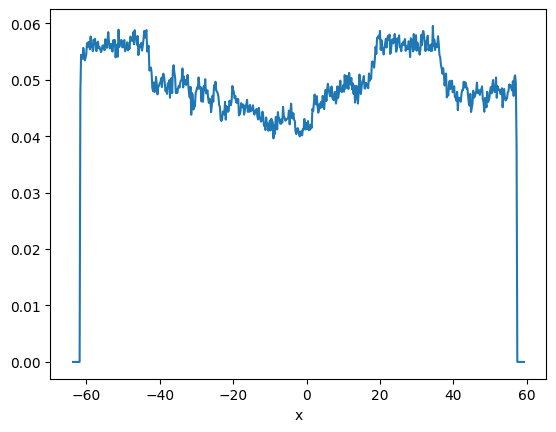

In [58]:
# plt.plot(D.results.density.edges[2][:-1], z_density); plt.xlabel('z')
# np.savetxt(pre_dir+'z-density-x-axis.txt', D.results.density.edges[2][:-1])
# np.savetxt(pre_dir+'z-density-y-axis.txt', z_density)

plt.plot(-D.results.density.edges[0][:-1], x_density); plt.xlabel('x')
np.savetxt(pre_dir+'x-density-x-axis.txt', -D.results.density.edges[0][:-1])
np.savetxt(pre_dir+'x-density-y-axis.txt', x_density)
# plt.plot(D.results.density.edges[1][:-1], y_density); plt.xlabel('y')

""" xi = np.linspace(D.results.density.edges[0][:-1].min(), D.results.density.edges[0][:-1].max(), 100)
yi = np.linspace(D.results.density.edges[1][:-1].min(), D.results.density.edges[1][:-1].max(), 100)
zi = griddata((D.results.density.edges[0][:-1], D.results.density.edges[1][:-1]), xy_density, (xi[None,:], yi[:,None]), method='linear')
contourf_filled = plt.contourf(xi, yi, zi, 50, cmap='Blues_r')       # Blues_r Greens_r RdYlBu_r viridis  xx_r表示颜色反转 """

""" plt.imshow(xy_density, origin='upper', aspect='auto', cmap='RdBu_r')
# 添加颜色条
plt.colorbar(label='Density') """

# plt.ylim(0.03, 0.045)
# plt.ylabel('Density (particles/Å³)')
plt.show()

### 3.1.4 Z-axis density with ectoolkits

H_idx=[80, 85, 86, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 142, 143, 144, 145, 148, 149, 152, 161, 164],
 O_idx=[199, 200, 201, 202, 204, 206, 207, 208, 209, 211, 212, 213, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 235, 237, 242]

ToolKit: Perform Atom Density Analysis
ToolKit: Read Structure File: ../activate-learning/iter10/model-0-with-CV10_MetaD-2000ps(height-0.05_d_O12_Fe_wall-O2H-0.2_wall-O1H-0.2_wall-d-FeO1_wall-d-FeO2_wall-O1-O2)-模拟O2吸附于位点-增加采样时间--※用于label/XDATCAR-double-z
ToolKit: Read the Cell Info: [10, 8.3, 40]
ToolKit: Read Surface 1 Atoms Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 52, 176, 177, 178, 179]
ToolKit: Read Surface 2 Atoms Index: [26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 3

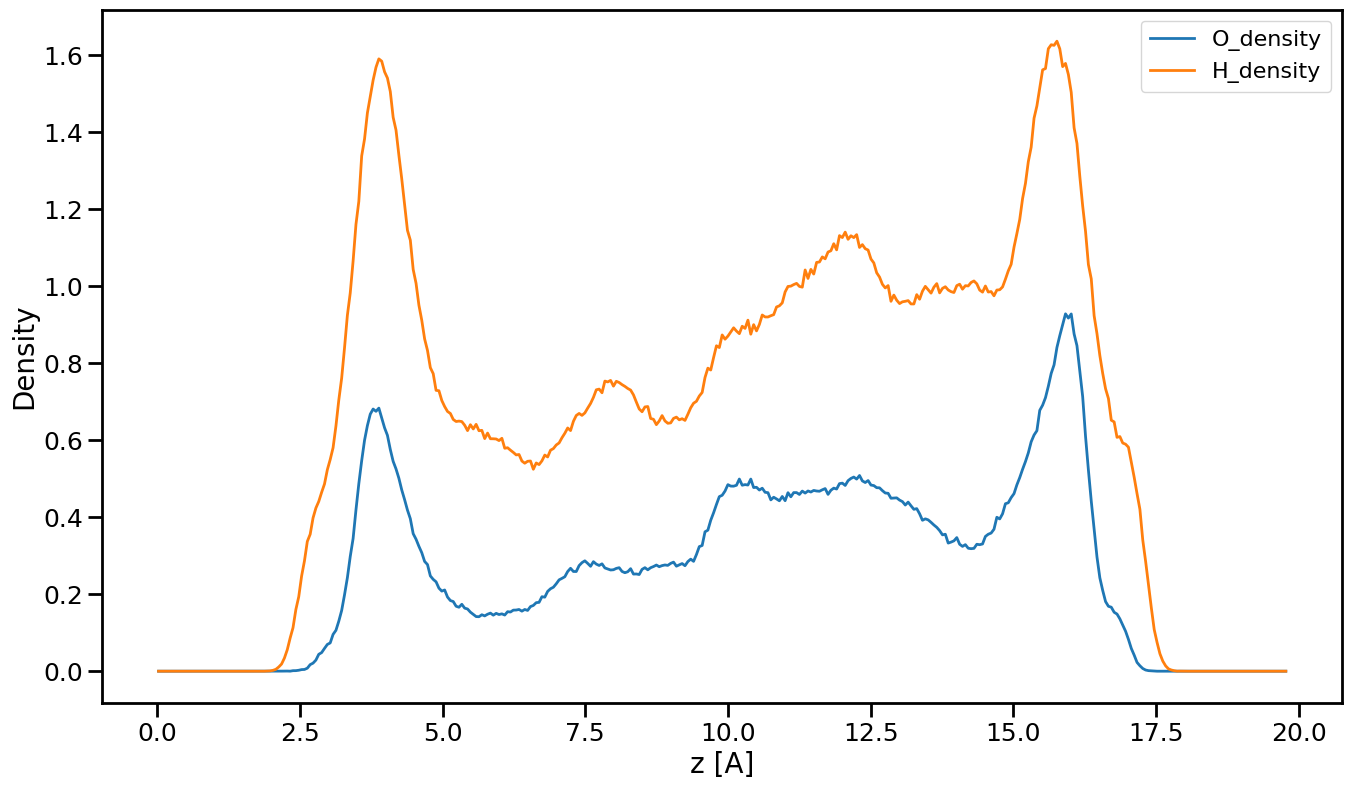

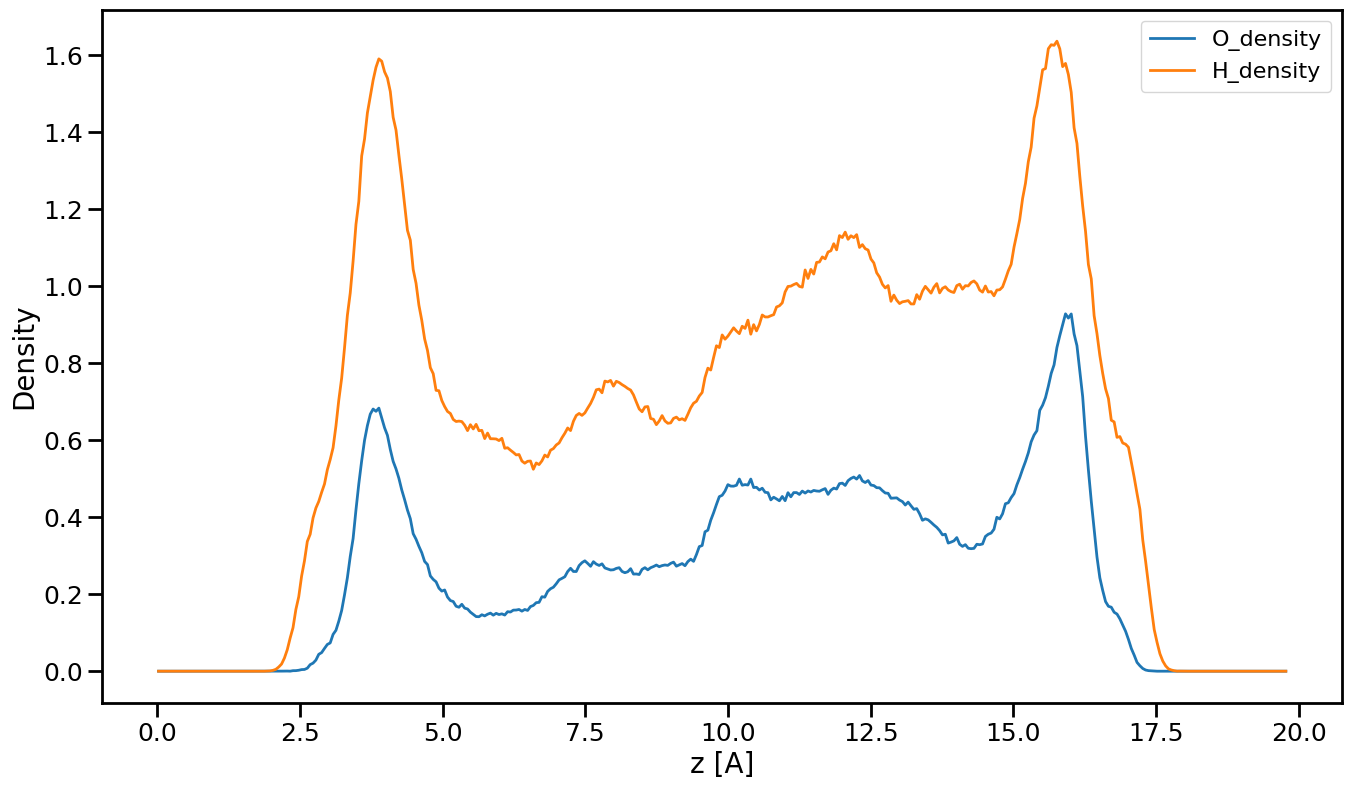

In [3]:
from ectoolkits.analysis.atom_density import AtomDensity        # thanks Dr. zhuang yongbin
from ase.io import read
pre_dir= '../activate-learning/iter10/model-0-with-CV10_MetaD-2000ps(height-0.05_d_O12_Fe_wall-O2H-0.2_wall-O1H-0.2_wall-d-FeO1_wall-d-FeO2_wall-O1-O2)-模拟O2吸附于位点-增加采样时间--※用于label/'
# a = read(pre_dir+'Fe-C-N4-sol-OOH-2.data', format='lammps-data', Z_of_type={1:6, 2:26, 3:1, 4:7, 5:8}, style='atomic', sort_by_id=False, units='metal')
a = read(pre_dir+'POSCAR-double-z', format='vasp')

posttions = a.get_positions()                                            # !!!注意, 选原子时候需要使用初始构型!!!
H_idx = [i for i,pos in enumerate(posttions) if 12 <= pos[2] <= 28 if a[i].symbol == 'H']
O_idx = [i for i,pos in enumerate(posttions) if 12 <= pos[2] <= 28 if a[i].symbol == 'O']
# O_idx = list(range(47,63))
O_idx.remove(214)
O_idx.remove(215)
print(f'H_idx={H_idx},\n O_idx={O_idx}\n')

# surf1=list(range(0,31)); surf2=list(range(124, 155))
surf1=[i for i,pos in enumerate(posttions) if 8 <= pos[2] <= 12]
surf2=[i for i,pos in enumerate(posttions) if 29 <= pos[2] <= 30]

inp_dict={
     # "xyz_file": "../activate-learning/iter11/model-0-with-CV9_MetaD-2000ps(height-0.05_path_O1H_O2-H_O1-O2_Fe-O1_wall-O2H-2.2_wall-O1H-2.2_wall-d-FeO1_wall-O1-O2_wall-cell.z_wall-pp.z)_full-path-待分析/dump_stage1.xyz",
     "xyz_file": pre_dir+"XDATCAR-double-z",     # pre_dir+"dump_stage1.xyz"
    #  "xyz_file": "../activate-learning/iter11/water_density_analysis_by_z_direction/正式跑MD_3.6ps/dump_stage2.xyz",
     "cell": [10, 8.3, 40],
     "surf2": surf2,        # here use surf 1 as surf 2
     "surf1": surf1,
     "density_type":[
         {
             "element": "O",
             "idx_method": "manual",
             "idx_list": O_idx,
             "density_unit": "water",
             "dz": 0.05,
             "name": "O_density"
             },
         {
             "element": "H",
             "idx_method": "manual",
             "idx_list": H_idx,
             "density_unit": "water",
             "dz": 0.05,
             "name": "H_density"
             }
         ]
 }
ad = AtomDensity(inp_dict)
ad.run()

# detail information is accessible in
ad.atom_density
ad.atom_density_z

# get average denstiy from center
width_list = [5, 6, 7, 8, 9, 10]
all_cent_density = ad.get_ave_density(width_list)

# quick plot for denstiy
# if you want to symmetrize the density profile, set sym=True
ad.plot_density(sym=False)

### 3.1.5 density with ovito

In [ ]:
#------------有待测试----------------
# Head files below has been imported in the head of this file:
# from ovito.io import import_file, export_file
# from ovito.modifiers import ComputePropertyModifier,TimeAveragingModifier,HistogramModifier

# 读取模拟数据
pipeline = import_file('./dump_stage-iter03-withMetaD-path-1.xyz')

# 计算密度
modifier = ComputePropertyModifier(
    output_property='Density',
    expressions=['Position.Z', '0.5']
)
pipeline.modifiers.append(modifier)
# pipeline.modifiers.append(TimeAveragingModifier(operate_on='table:density'))

# data = pipeline.compute()
# density = data.particles['Density']
# data.attributes["Density"] = density

# 定义管道修正函数
def calculate_density(frame, data):
    #读取原子位移，存入到变量displacement_magnitudes
    density = data.particles['Density']
    #以上计算结果存入到全局变量MSD中
    data.attributes["Density"] = density 

#将以上自定义的msd计算函数添加到管道修饰中
pipeline.modifiers.append(calculate_density)


export_file(pipeline,"density.txt", format="txt/attr", columns = ["Timestep", "Density"], multiple_frames = True)

## 3.2 pH

In [4]:
def cal_pH(a,b,c, N_H, water_nums, if_hex=False, use_default_density=False):
    # calculation water density
    Na = 6.02214076e23                          # define Avogadro constant, mol^-1
    mol_mass_H2O = 18.01528                     # g/mol
    mass = (water_nums * mol_mass_H2O) / Na     # g
    if if_hex:
        volume = a * b * c * 1e-24              # cm^3
    else:
        volume = a * (b*1.7321/2) * c * 1e-24    # cm^3
    if use_default_density:
        density = 0.997047                       # g/cm^3 at 25 °C, 1 atm
    else:
        density = mass / volume                  # g/cm^3
    volume = mass / density                      # L
    c_H = (N_H/Na) / (volume*1e-3)               # mol/L
    pH = -np.log10(c_H)
    print(f'pH of water_{water_nums} and number of H+_{N_H} is {pH:.25f}')

In [15]:
cal_pH(a=11,b=11,c=16, if_hex=False, N_H=1, water_nums=56, use_default_density=True)

pH of water_56 and number of H+_1 is 0.0051134123896842149231690


# 4. RDF analysis

## 4.1 water RDF reference 王阳刚 NC

In [3]:
from ovito.io import import_file
from ovito.data import CutoffNeighborFinder
import numpy as np
import matplotlib.pyplot as plt

water RDF from [reference's SI figure 2](https://www.nature.com/articles/s41467-022-29357-7#MOESM1)
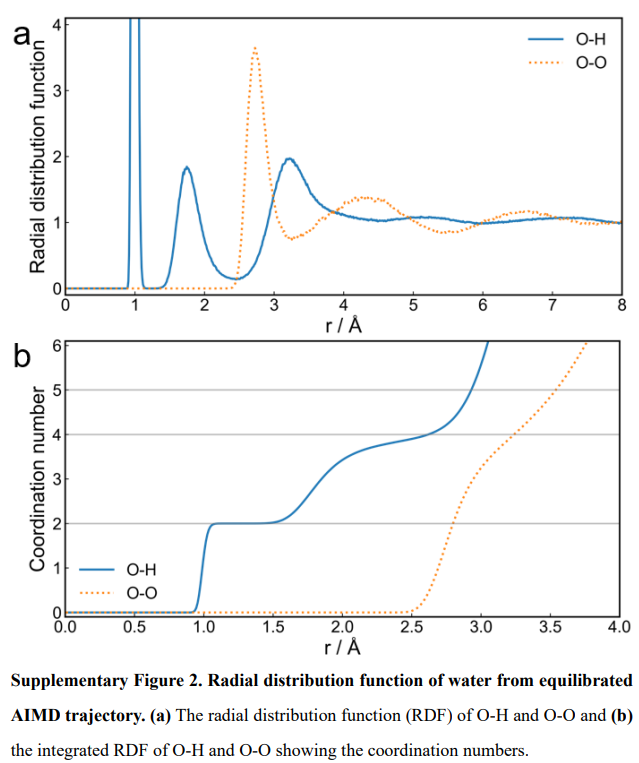

## 4.2 Method-1 OVITO

RDF has benn calculated


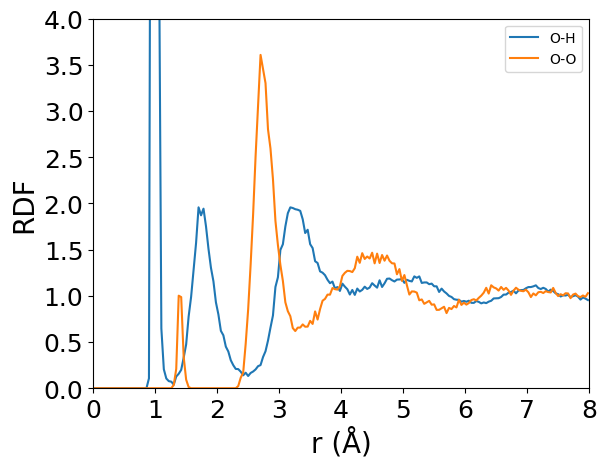

<Figure size 2000x1000 with 0 Axes>

In [16]:
# pipeline = import_file('../Fe-C-N4-sol-10-10-2/dump_stage-300K-from-ice-2-water-4.xyz')
# pre_dir = 'E:\\Project\\Fe-C-N4\\trajectory\\activate-learning\\iter10\\water_60_5ps_DP'
# pre_dir = '../activate-learning/iter10/model-0-with-CV10_MetaD-2000ps(height-0.05_d_O12_Fe_wall-O2H-0.2_wall-O1H-0.2_wall-d-FeO1_wall-d-FeO2_wall-O1-O2)-模拟O2吸附于位点-增加采样时间--※用于label/'
pre_dir = '../activate-learning/iter11/figure_s_z_reaction-production/reaction/'
# pipeline = import_file(pre_dir + '/dump_stage1.xyz')
pipeline = import_file(pre_dir + 'dump_stage1_less-structure.xyz')

# pipeline.modifiers.append(ExpressionSelectionModifier(expression='ParticleType == 5 || ParticleType == 3')) # ParticleIdentifier
pipeline.modifiers.append(SelectTypeModifier(property='Particle Type', types={5, 3}))

pipeline.modifiers.append(CoordinationAnalysisModifier(cutoff=8, number_of_bins=200, partial=True))

pipeline.modifiers.append(TimeAveragingModifier(operate_on='table:coordination-rdf'))
# Access the output DataTable:
# rdf_table = pipeline.compute().tables['coordination-rdf']    # add .xy()   can change DataTable to array
# rdf_5_3 = rdf_table['H-O']                                   # 单独获取 H-O 的rdf

export_file(pipeline, pre_dir+"\\rdf.txt","txt/table",key="coordination-rdf[average]"); print('RDF has benn calculated')
data = np.loadtxt(pre_dir+'\\rdf.txt')

x = data[:,0]       # r
y1 = data[:,12]     # O-H 12 for Fe-C-N4/sol structure    2 for water structure
y2 = data[:,15]     # O-O 15 for Fe-C-N4/sol              3 for water structure
plt.plot(x,y1,label='O-H')
plt.plot(x,y2,label='O-O')
plt.xlabel('r (Å)',fontsize=20)
plt.ylabel('RDF',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.0,4)
plt.xlim(0,8)
# plt.title('RDF of O-H and O-O')
plt.legend()
plt.figure(figsize=(20,10))
plt.show()

In [ ]:
#------------有待测试----------------

from ovito.io import import_file, export_file
from ovito.modifiers import ComputePropertyModifier,TimeAveragingModifier,HistogramModifier

# 读取模拟数据
pipeline = import_file('./dump_stage-iter03-withMetaD-path-1.xyz')

# 计算密度
modifier = ComputePropertyModifier(
    output_property='Density',
    expressions=['Position.Z', '0.5']
)
pipeline.modifiers.append(modifier)
# pipeline.modifiers.append(TimeAveragingModifier(operate_on='table:density'))

# data = pipeline.compute()
# density = data.particles['Density']
# data.attributes["Density"] = density

# 定义管道修正函数
def calculate_density(frame, data):
    #读取原子位移，存入到变量displacement_magnitudes
    density = data.particles['Density']
    #以上计算结果存入到全局变量MSD中
    data.attributes["Density"] = density 

#将以上自定义的msd计算函数添加到管道修饰中
pipeline.modifiers.append(calculate_density)


export_file(pipeline,"density.txt", format="txt/attr", columns = ["Timestep", "Density"], multiple_frames = True)

## 4.3 Method-2 ASE

In [2]:
from ase.io import read
from ase.geometry.analysis import Analysis
from ase.visualize import view
from scipy.ndimage import gaussian_filter1d
import numpy as np

In [ ]:
def lammps_dump_text_to_vasp_poscar(file_name,elements_list):
    a = read(file_name, index=":", format="lammps-dump-text", specorder=elements_list)
    return a
atoms = lammps_dump_text_to_vasp_poscar("../Fe-C-N4-sol-10-10-2/dump_stage-300K.xyz",['C','Fe','H','N','O'])
# view(atoms)


In [7]:
atoms = read('C:\\Users\\18040\\Desktop\\OUTCAR')
res = Analysis(atoms).get_rdf(rmax=8, nbins=200, elements=('Cs', 'Cs'))

100%|██████████| 1/1 [00:00<00:00, 50.00it/s]


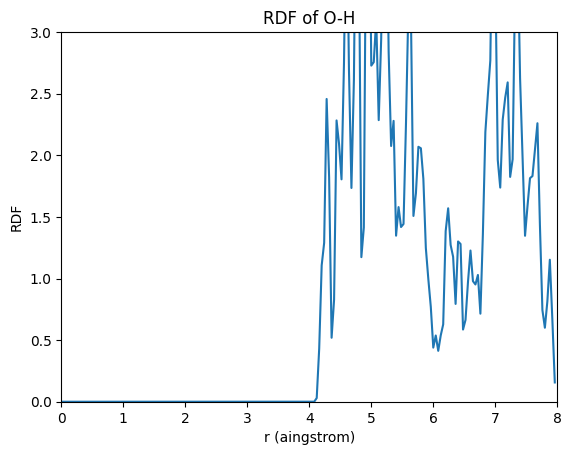

In [8]:
rdf  =np.zeros(200)    #200 is nbins
for i in res:
    rdf += i
rdf  =gaussian_filter1d(rdf/len(res), sigma=0.75)    # smoothing
# print(rdf)
index_list = []
rdf_list = []
for index, rdf_2 in enumerate(rdf):
    index_list.append(index*0.04)
    rdf_list.append(rdf_2)

plot = plt.plot(index_list, rdf_list)
plt.xlabel('r (aingstrom)')
plt.ylabel('RDF')
plt.ylim(0,3)
plt.xlim(0,8)
plt.title('RDF of O-H')
plt.show()

## 4.4 Method-3 MDAnalysis

100%|██████████| 80001/80001 [01:33<00:00, 859.84it/s]


" # CNs from RDF\nr = rdf.results.bins\ng_r = rdf.results.rdf\nvolume = u.dimensions[0] * u.dimensions[1] * u.dimensions[2]\nnum_density = u.atoms.n_atoms / volume\ncoordination_number = 4*np.pi * num_density * np.cumsum(g_r * r**2) * (r[1] - r[0])\nplt.plot(r, coordination_number, label='Coordination Number')\nplt.legend() "

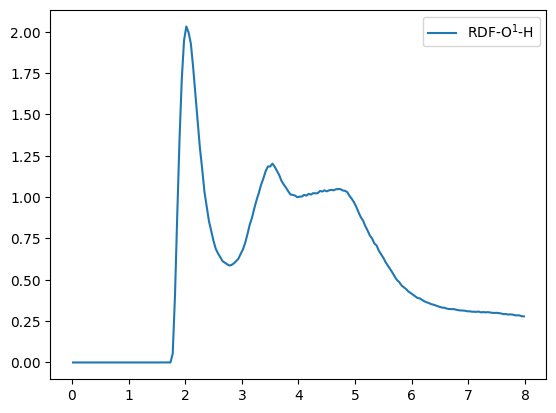

In [31]:
#Calculate the rdf between A-B atoms, allowing for dynamic selection of regions
pre_dir = '../activate-learning/iter10/model-0-with-CV10_MetaD-2000ps(height-0.05_d_O12_Fe_wall-O2H-0.2_wall-O1H-0.2_wall-d-FeO1_wall-d-FeO2_wall-O1-O2)-模拟O2吸附于位点-增加采样时间--※用于label/'
u = mda.Universe(pre_dir+'end-stage-end.data', pre_dir+'dump_stage1.xyz', format='LAMMPSDUMP', atom_style='id type x y z')
hydrogens = u.select_atoms('type 3'); o_atoms_in_waters = u.select_atoms('type 5 and not (id 62:63)'); oxygen = u.select_atoms('id 62:63'); water_O_around_O2 = u.select_atoms('type 5 and (around 4 id 62:63)',updating=True); Fe_N4_C = u.select_atoms('id 1:31'); Fe = u.select_atoms('type 2')
oxygen_within_25_Fe = u.select_atoms('(id 62:63) and (around 3.6  type 2)',updating=True)
oxygen_within_20_Fe = u.select_atoms('(id 62:63) and (around 3.4 type 2)',updating=True)
oxygen_d_Fe_20_25 = oxygen_within_25_Fe - oxygen_within_20_Fe

# select_A = u.select_atoms('name OW and (prop z > 30 and prop z < 36)', updating=True)  #Select A atoms
# select_B = u.select_atoms('name OW and (prop z > 30 and prop z < 36)', updating=True)  #Select B atoms, Can be different from A

rdf = InterRDF(oxygen, hydrogens, range=(0.0, 8.0), nbins=200, n_threads=12, verbose=True)
rdf.run()

rdf.results.rdf[0] = 0.0    # when r=0, RDF=0

np.savetxt(pre_dir+"rdf.txt", np.column_stack((rdf.results.bins, rdf.results.rdf)), header="r (Angstrom)\t g(r)")
plt.plot(rdf.results.bins, rdf.results.rdf, label='RDF-O$^1$-H')
# plt.ylim(0,4)
plt.legend()

""" # CNs from RDF
r = rdf.results.bins
g_r = rdf.results.rdf
volume = u.dimensions[0] * u.dimensions[1] * u.dimensions[2]
num_density = u.atoms.n_atoms / volume
coordination_number = 4*np.pi * num_density * np.cumsum(g_r * r**2) * (r[1] - r[0])
plt.plot(r, coordination_number, label='Coordination Number')
plt.legend() """

## 4.5 Method-4  ASE 轨迹分段 计算所有pair的RDF, 时间平均

In [ ]:
from ase.io import read, write
from ase.geometry.analysis import Analysis
import numpy as np

trajectory = read('C:\\Users\\18040\\Desktop\\RDF\\OUTCAR',index=':')
section = 5     # 将轨迹为5段
rmax = 10       # RDF径向距离最大值, rmax should < cell length/2
nbins = 200     # RDF点个数

steps_per_file = len(trajectory) // section
set_symbol = trajectory[0].symbols.species()   # {'Bi', 'Cs', 'Cu', 'Br'}

""" # 创建5个轨迹文件
for i in range(1,6):
    write(f'C:\\Users\\18040\\Desktop\\XDATCAR-{i}', trajectory[(i-1)*steps_per_file:steps_per_file*i], format='vasp-xdatcar', label=f'Step_{(i-1)*steps_per_file}-{i*steps_per_file}') """

# 创建元素组合
element_combinations = []
for element_i in set_symbol:
    for element_j in set_symbol:
        combine = [element_i, element_j]
        if (combine and combine[::-1]) not in element_combinations:
            element_combinations.append(combine)

r_list = []     # r_list 初始化
for part in range(0,section):
    for element_combine in element_combinations:
        if part == 0:
            a = Analysis(trajectory[0:1]).get_rdf(rmax=rmax, nbins=nbins, imageIdx=0, elements=(element_combine[0], element_combine[1]),return_dists=True)
            r_list = a[0][1]
            save_2D_list_init = [[i,j] for i,j in zip(a[0][0],r_list)]
            np.savetxt(f'C:\\Users\\18040\\Desktop\\RDF\\RDF_{element_combine[0]}-{element_combine[1]}_init', save_2D_list_init)
        rdf = Analysis(trajectory[part*steps_per_file:(part+1)*steps_per_file]).get_rdf(rmax=rmax, nbins=nbins, elements=(element_combine[0], element_combine[1]))  # rmax should < cell length/2
        ave_rdf = np.sum(rdf,axis=0)/len(rdf)
        save_2D_list = [[i,j] for i,j in zip(ave_rdf,r_list)]
        np.savetxt(f'C:\\Users\\18040\\Desktop\\RDF\\RDF_{element_combine[0]}-{element_combine[1]}_step_{part*steps_per_file}-{(part+1)*steps_per_file}', save_2D_list)


# 5.  Coordination Number

## 5.1 switch function properties

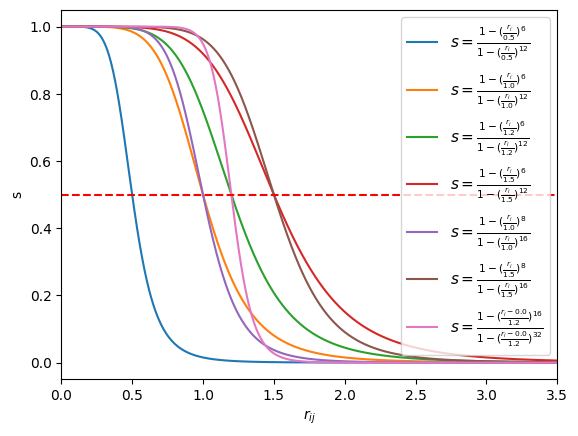

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# 定义r的范围
r = np.linspace(0, 3.5, 1000)

# 定义函数
s0 = (1 - (r / 0.5) ** 6) / (1 - (r / 0.5) ** 12)
s1 = (1 - (r / 1.0) ** 6) / (1 - (r / 1.0) ** 12)
s2 = (1 - (r / 1.2) ** 6) / (1 - (r / 1.2) ** 12)
s3 = (1 - (r / 1.5) ** 6) / (1 - (r / 1.5) ** 12)
s4 = (1 - (r / 1.0) ** 8) / (1 - (r / 1.0) ** 16)
s5 = (1 - (r / 1.5) ** 8) / (1 - (r / 1.5) ** 16)
s6 = (1 - ((r -0.0)/ 1.2) ** 16) / (1 - ((r -0.0)/ 1.2) **32)   #d_0=1.2

# 绘制图像
plt.plot(r, s0, label=r'$s=\frac{1-(\frac{r_i}{0.5})^6}{1-(\frac{r_i}{0.5})^{12}}$')
plt.plot(r, s1, label=r'$s=\frac{1-(\frac{r_i}{1.0})^6}{1-(\frac{r_i}{1.0})^{12}}$')
plt.plot(r, s2, label=r'$s=\frac{1-(\frac{r_i}{1.2})^6}{1-(\frac{r_i}{1.2})^{12}}$')
plt.plot(r, s3, label=r'$s=\frac{1-(\frac{r_i}{1.5})^6}{1-(\frac{r_i}{1.5})^{12}}$')
plt.plot(r, s4, label=r'$s=\frac{1-(\frac{r_i}{1.0})^8}{1-(\frac{r_i}{1.0})^{16}}$')
plt.plot(r, s5, label=r'$s=\frac{1-(\frac{r_i}{1.5})^8}{1-(\frac{r_i}{1.5})^{16}}$')
plt.plot(r, s6, label=r'$s=\frac{1-(\frac{r_i-0.0}{1.2})^{16}}{1-(\frac{r_i-0.0}{1.2})^{32}}$')
plt.xlabel('$r_{ij}$')
plt.xlim(0, 3.5)
plt.ylabel('s')
plt.legend(fontsize='11', loc='upper right')
plt.axhline(0.5, color='r', linestyle='--')
plt.show()

In [4]:
r_1=1.019
r_2=1.21
r_3=2.080
d_FeO1 = 2.6

s6_1 = (1 - ((r_1 -0.0)/ 1.2) ** 16) / (1 - ((r_1 -0.0)/ 1.2) ** 32)   #d_0=1.2
print(s6_1)
s6_2 = (1 - ((r_2 -0.0)/ 1.2) ** 16) / (1 - ((r_2 -0.0)/ 1.2) ** 32)   #d_0=1.2
print(s6_2)
s6_3 = (1 - ((r_3 -0.0)/ 1.2) ** 16) / (1 - ((r_3 -0.0)/ 1.2) ** 32)   #d_0=1.2
print(s6_3)
s_Fe_O1 = (1 - (d_FeO1 / 2.2) ** 6) / (1 - (d_FeO1 / 2.2) ** 12)
print(s_Fe_O1)

0.9318840400914479
0.466853474287082
0.00015059868103109328
0.2684846409037385


## 5.2 Cal coordination number using OVITO

please read ref [OVITO manual](https://www.ovito.org/docs/current/python/modules/ovito_modifiers.html#ovito.modifiers.CoordinationAnalysisModifier)

In [ ]:
# 导入你的数据文件
pipeline = import_file('../activate-learning/iter10/model-0-with-CV10_MetaD-1000ps(height-0.05_O2-H_O1-O2_wall-O2H-2.2__wall-O1H_wall-d-FeO1_wall-O1-O2_wall-cell.z)-看起来可以-转战pathCV--※用于label/dump_stage1.xyz')
for t in pipeline.compute().particles.particle_types.types:
    print("Type %i: %s" % (t.id, t.name))

# 创建一个配位数分析修饰器，设置截止距离,并修饰器添加到管道中
modifier = CoordinationAnalysisModifier(cutoff=1.2, number_of_bins = 200)
pipeline.modifiers.append(modifier)
# 计算配位数
data = pipeline.compute()
# 获取配位数
coor_nums = data.particles['Coordination']
for i in range(data.particles.count):
    print(coor_nums[i])

## 5.3 Cal coordination number using MDAnalysis

In [ ]:
#  test code
pre_dir = '../activate-learning/iter10/model-0-with-CV10_MetaD-1000ps(height-0.05_O2-H_O1-O2_wall-O2H-2.2__wall-O1H_wall-d-FeO1_wall-O1-O2_wall-cell.z)-看起来可以-转战pathCV--※用于label/'
u = mda.Universe(pre_dir+'Fe-C-N4-sol-OOH.data', pre_dir+'dump_stage1.xyz', format='LAMMPSDUMP', atom_style='id type x y z')

hydrogens = u.select_atoms('type 3')        # type 1 H
oxygens = u.select_atoms('type 5')          # type 2 O
o_atoms_abos = u.select_atoms('id 63')      # gas oxygen atoms index 62 63  select method: id 62:63; bynum 62:63; index 61:62; id 78 or id 87

_, dis = capped_distance(o_atoms_abos, hydrogens, max_cutoff=3.5, box=u.dimensions)

def coor_nums(dis_array, r0, nn, d0=0, mm=None):
    if mm == None:
        mm = nn*2
    cn_list = []
    for r in dis_array:
        cn = (1 - ((r -d0)/ r0) ** nn) / (1 - ((r -d0)/ r0) ** mm)
        print(f'When distance = {r}, coordination={cn}')
        cn_list.append(cn)
    return sum(cn_list)

CN_O2_H = coor_nums(dis, r0=1.5, nn=8)

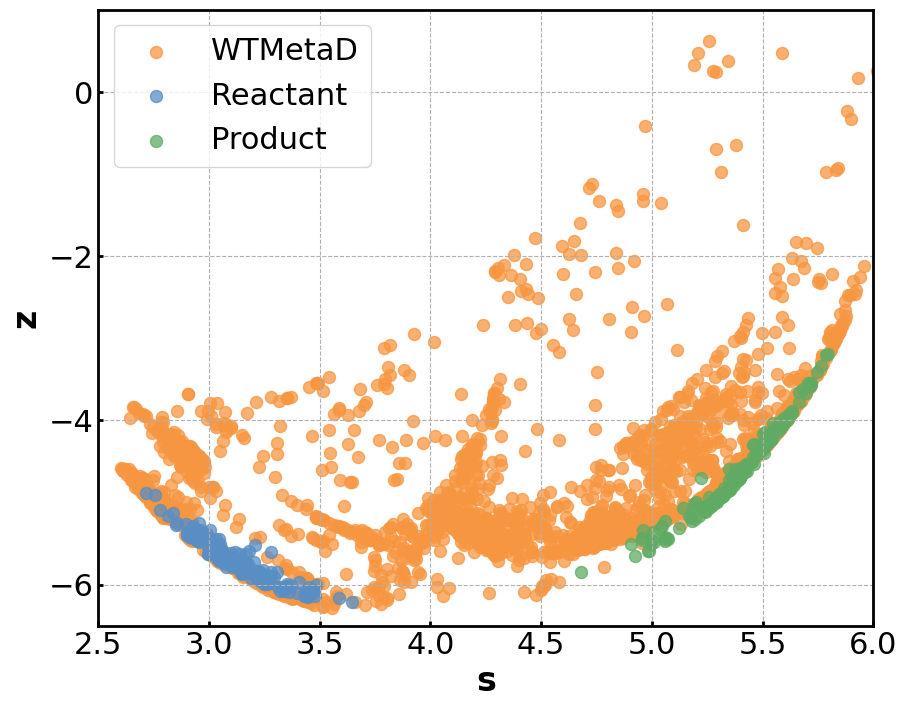

In [46]:
# Path CV
class CV_calculate:
    def __init__(self, universe, reference, configuration):
        u = universe
        box = u.dimensions
        ref = u.select_atoms(reference)
        conf = u.select_atoms(configuration)
        self.u = u
        self.box = box
        self.ref = ref
        self.conf = conf
    
    def distance(self):
        if len(self.ref) != 1 or len(self.conf) != 1:
            return 'Reference and configuration should be single atom when calculating distance. Or you should define reference and configuration first.'
        else:
            dist = distance_array(self.ref, self.conf, box=self.box)
        return dist[0][0]
    
    def coor_nums(self, r0, nn, d0=0, mm=None):
        if mm == None:
            mm = nn*2
        _, dis = capped_distance(self.ref, self.conf, max_cutoff=3.5, box=self.box)
        cn_list = []
        for r in dis:
            cn = (1 - ((r -d0)/ r0) ** nn) / (1 - ((r -d0)/ r0) ** mm)
            # print(f'When distance = {r}, coordination={cn}')
            cn_list.append(cn)
        return sum(cn_list)
    
    def coor_nums_open(self, r0, nn, d0=0, mm=None):
        if mm == None:
            mm = nn*2
        dis = distance_array(self.ref, self.conf, box=self.box, backend='OpenMP')
        cn_list = []
        for r_list in dis:
            for r in r_list:
                cn = (1 - ((r -d0)/ r0) ** nn) / (1 - ((r -d0)/ r0) ** mm)
                cn_list.append(cn)
        return sum(cn_list)

def calculate_s_z(X_values, Xi_values, lambda_val=0.25, R=1.0):
    N = len(Xi_values)
    X_Xi = np.sqrt(np.sum((X_values- Xi_values)**2, axis=1))        # when 2D CN, use ", axis=1" for np.sum
    # X_Xi = X_values- Xi_values        # when 1D CN, use this
    exp_values = np.exp(-lambda_val * R * (X_Xi)**2)
    s_values = np.sum((np.arange(1, N+1) * exp_values.T), axis=0) / np.sum(exp_values, axis=0)
    z_values = (-1 / lambda_val) * np.log(np.sum(exp_values, axis=0))
    return s_values, z_values

def cal_s_z(X_values_selected, Xi_values, json_file_path):
    s_z = [[],[]]
    for i in X_values_selected:
        X_values = i
        s_values, z_values = calculate_s_z(X_values, Xi_values)
        s_z[0].append(s_values)
        s_z[1].append(z_values)
        # plt.scatter(s_values, z_values)
    with open(json_file_path,'w') as f:
        json.dump(s_z, f)

def plot_s_z(json_file_path_dist={}):
    '''This function input needs a dictionary with keys of AIMD(abandon), MetaD, Reaction and Product. The value of those keys are a list of json file path.'''
    # AIMD_path_list = json_file_path_dist['AIMD']
    MetaD_path_list = json_file_path_dist['MetaD']
    Reaction_path_list = json_file_path_dist['Reaction']
    Product_path_list = json_file_path_dist['Product']
    
    def get_s_z(json_file_path_list):
        s_z_all = []
        for json_file_path in json_file_path_list:
            with open(json_file_path, 'r') as f:
                s_z = json.load(f)
                s_z_all.append(s_z)
        s_list = [s for sub_s in s_z_all for s in sub_s[0]]
        z_list = [z for sub_z in s_z_all for z in sub_z[1]]
        return s_list, z_list
    s_list_MetaD, z_list_MetaD = get_s_z(MetaD_path_list)

    plt.figure(figsize=(10,8))
    plt.grid(ls="--")
    plt.scatter(s_list_MetaD, z_list_MetaD, alpha=0.75, s=75, color='#F79640', label='WTMetaD')
    # s_list_AIMD, z_list_AIMD = get_s_z(AIMD_path_list)
    # plt.scatter(s_list_AIMD, z_list_AIMD, alpha=0.2, color='red', label='AIMD')
    s_list_reaction, z_list_reaction = get_s_z(Reaction_path_list)
    plt.scatter(s_list_reaction, z_list_reaction, alpha=0.75, s=75, color='#588EC4', label='Reactant')
    s_list_Product, z_list_Product = get_s_z(Product_path_list)
    plt.scatter(s_list_Product, z_list_Product, alpha=0.75, s=75, color='#60AB64', label='Product')
    plt.xlim(2.5, 6)
    plt.ylim(-6.5, 1)
    plt.xlabel('s',fontsize=24,fontweight='bold')
    plt.ylabel('z',fontsize=24,fontweight='bold')
    plt.xticks(fontsize=22)
    plt.yticks(np.arange(-6,2,2),fontsize=22)
    plt.legend(loc=0,fontsize=22)
    plt.setp(plt.gca().spines.values(),linewidth=2)   # 边框线宽设为2
    plt.tick_params(direction='in', width=2)    # 刻度线向内
    # plt.title('Plot of z against s for multiple X_values')
    
    plt.show()

def plot_s_z_from_list(json_file_path_list=[]):
    s_z_all = []
    for json_file_path in json_file_path_list:
        with open(json_file_path, 'r') as f:
            s_z = json.load(f)
            s_z_all.append(s_z)
    s_list = [s for sub_s in s_z_all for s in sub_s[0]]
    z_list = [z for sub_z in s_z_all for z in sub_z[1]]
    # pd.DataFrame({'s': s_list, 'z': z_list}).to_excel('E:\\Project\\Fe-C-N4\\dataset\\Initial-dataset\\training_data\\'+'s_z_list.xlsx', index=False)

    plt.scatter(s_list, z_list, alpha=0.5)
    plt.xlabel('s')
    plt.ylabel('z')
    plt.title('Plot of z against s for multiple X_values')
    plt.show()

if __name__ == '__main__':

    """ pre_dir = '../activate-learning/training_data/C26N4Fe1O32H61/'
    # u = mda.Universe(pre_dir+'dp_1753.xyz')
    u = mda.Universe(pre_dir+'production.data', pre_dir+'dump_stage1_less-structure.xyz', format='LAMMPSDUMP', atom_style='id type x y z')

    X_values_multi = pd.DataFrame(columns=['frame','CN_O2_H','CN_O1_O2','CN_Fe_O1','CN_O1_H'])
    for i, ts in enumerate(u.trajectory):
        O_1='index 61'; O_2='index 60'; type_H='type 3'# 'element H'
        CN_O1_H  = CV_calculate(u, O_1, type_H).coor_nums_open(1.5,8)   # for O32H64 O_1 index 54  other is 61
        CN_O2_H  = CV_calculate(u, O_2, type_H).coor_nums_open(1.5,8)
        CN_Fe_O1 = CV_calculate(u, 'index 30', O_1).coor_nums_open(2.2,6)
        CN_O1_O2 = CV_calculate(u, O_1, O_2).coor_nums_open(1.8,6)    # for O32H64 O_1 index 54  other is 61
        X_values_multi = X_values_multi.append({'frame': i, 'CN_O2_H': CN_O2_H, 'CN_O1_O2': CN_O1_O2, 'CN_Fe_O1': CN_Fe_O1, 'CN_O1_H': CN_O1_H}, ignore_index=True)

    # X_values_multi = np.array([[0,0.9,0.9,0],[1,0.8,0.9,0],[1.3,0.3,0.9,0],[2,0.3,0.9,0],[2,0,0.9,1],[2,0,0.9,2],[2,0,0,2]]) 
    X_values_selected = X_values_multi[['CN_O2_H','CN_O1_O2','CN_Fe_O1','CN_O1_H']].values      # 想同时选多列? 将想要的列组成一个列表，然后用这个列表作为索引
    Xi_values = np.array([[0,0.9,0.9,0],[1,0.8,0.9,0],[1.3,0.3,0.9,0],[2,0.3,0.9,0],[2,0,0.9,1],[2,0,0.9,2],[2,0,0,2]])
    json_file_path = pre_dir + 's_z.json'
    cal_s_z(X_values_selected, Xi_values, json_file_path) """
    plot_s_z({'MetaD':['../activate-learning/training_data/C26N4Fe1O32H61/s_z_730.json',
              '../activate-learning/training_data/C26N4Fe1O32H64/s_z_1753.json',
              '../activate-learning/training_data/C26N4Fe1O34H64/s_z_47.json'],
              'Reaction':['../activate-learning/iter11/figure_s_z_reaction-production/reaction/s_z_reaction.json'],
              'Product':['../activate-learning/iter11/figure_s_z_reaction-production/production/s_z_production.json']})
    """ plot_s_z_from_list([]) """

In [26]:
pre_dir = '../activate-learning/iter11/figure_s_z_reaction-production/reaction/'

def extract_frames(input_file, output_file, step):
    with open(input_file, 'r') as f_in, open(output_file, 'w') as f_out:
        frame_count = 0
        for line in f_in:
            # If the line starts with "ITEM: TIMESTEP", it's the start of a new frame
            if line.startswith("ITEM: TIMESTEP"):
                frame_count += 1
            # If the current frame number is a multiple of the step, write the line to the output file
            if frame_count % step == 0:
                f_out.write(line)

# Call the function to extract every 2500th frame from "input.lammpstrj" and write them to "output.lammpstrj"
extract_frames(pre_dir+"dump_stage1_less-structure.xyz", pre_dir+"dump_stage1_less-structure-lessless.xyz", 2)

# 6. Structure Space Analysis

## 6.1 Collect dataset

In [ ]:
import uuid
import shutil
import argparse

from dpdata import LabeledSystem

def to_ase(data):
	'''Convert System to ASE Atoms object.'''
	from ase import Atoms
	from ase.calculators.singlepoint import SinglePointCalculator

	structures = []
	species = [data['atom_names'][tt] for tt in data['atom_types']]

	for ii in range(data['coords'].shape[0]):
		structure = Atoms(
			symbols=species,
			positions=data['coords'][ii],
			pbc=not data.get('nopbc', False),		# Try to get pbc from a dict format(data) by key word 'nopbc', if not exist, return False
			cell=data['cells'][ii]
		)

		results = {
			'energy': float(data["energies"][ii]),
			'forces': data["forces"][ii]
		}
		if "virials" in data:
			# convert to GPa as this is ase convention
			# v_pref = 1 * 1e4 / 1.602176621e6
			vol = structure.get_volume()
			# results['stress'] = data["virials"][ii] / (v_pref * vol)
			results['stress'] = -data["virials"][ii] / vol

		structure.calc = SinglePointCalculator(structure, **results)
		structures.append(structure)

	return structures

if __name__ == '__main__':

	parser = argparse.ArgumentParser(formatter_class=argparse.RawTextHelpFormatter)

	parser.add_argument('path', type=str,
		help='path to the folder containing all the data')

	# parser.add_argument('type_map', nargs='+', type=str,
	# 	help='the type_map of the data')

	args = parser.parse_args()

	print('\nReading data from: %s' % args.path)
	images = []
	for subdir, dirs, files in os.walk(args.path):
		for file in files:
			if file == 'type.raw':
				print(subdir)
				# images += to_ase(LabeledSystem(subdir, fmt='deepmd/npy', type_map=args.type_map).data)		# use self define function, LabeledSystem.data is a dict with many atoms information
				images += LabeledSystem(subdir, fmt='deepmd/npy').to_ase_structure()	# use dpdata inner function

	print('\nWriting dataset to file: %s' % 'ase_dataset.db')
	filename = uuid.uuid4().hex
	write(args.path + filename + '.db', images)
	shutil.move(args.path + filename + '.db', 'ase_dataset.db')

## 6.2 Define Class CV_calculate

In [ ]:
from scipy.spatial import distance_matrix
import numpy as np

class CV_calculate:
    def __init__(self, atoms, reference, configuration):
        '''There are three functions in this class: coor_nums, coor_nums_mean, coor_nums_single'''
        u = atoms
        box = u.get_cell()
        ref = reference
        conf = configuration
        self.u = u
        self.box = box
        self.ref = ref
        self.conf = conf
    
    def coor_nums(self, r0, nn, d0=0, mm=None):
        if mm == None:
            mm = nn*2
        position_ref = [atom_i.position for atom_i in self.ref]
        position_conf = [atom_i.position for atom_i in self.conf]
        dis = distance_matrix(position_ref, position_conf)
        cn_list = []
        for r_list in dis:
            for r in r_list:
                cn = (1 - ((r -d0)/ r0) ** nn) / (1 - ((r -d0)/ r0) ** mm)
                # print(f'When distance = {r}, coordination={cn}')
                cn_list.append(cn)
        return sum(cn_list)
    
    def coor_nums_mean(self, r0, nn, d0=0, mm=None):
        if mm == None:
            mm = nn*2
        position_ref = [atom_i.position for atom_i in self.ref]
        position_conf = [atom_i.position for atom_i in self.conf]
        dis = distance_matrix(position_ref, position_conf)
        cn_list = []
        for r_list in dis:
            for r in r_list:
                cn = (1 - ((r -d0)/ r0) ** nn) / (1 - ((r -d0)/ r0) ** mm)
                # print(f'When distance = {r}, coordination={cn}')
                cn_list.append(cn)
        return np.mean(cn_list)
    
    def coor_nums_single(self, r0, nn, d0=0, mm=None):
        if mm == None:
            mm = nn*2
        dis = [self.u.get_distance(self.ref.index, atom_i.index) for atom_i in self.conf]
        cn_list = []
        for r in dis:
            cn = (1 - ((r -d0)/ r0) ** nn) / (1 - ((r -d0)/ r0) ** mm)
            # print(f'When distance = {r}, coordination={cn}')
            cn_list.append(cn)
        return sum(cn_list)

## 6.3 DPMD+PCA/t-SNE

In [ ]:
from ase.io import read
from pynep.select import FarthestPointSample
from deepmd.infer import DeepPot
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["TF_INTRA_OP_PARALLELISM_THREADS"] = "1" 
os.environ["TF_INTER_OP_PARALLELISM_THREADS"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# atoms = read('/home/qhyu/Project/Fe-C-N4/lmp/frozen_model/log_out/traj/POSCAR', format='vasp')
# trajs = read('/home/qhyu/Project/Fe-C-N4/lmp/frozen_model/log_out/traj/dump_stage1.xyz', index="-100:-10", format="lammps-dump-text", specorder=["C","Fe","H","N","O"])
trajs = read('/home/qhyu/Project/Fe-C-N4/Configuration_space_destribution/DP+PCA/ase_dataset_all_data.db', ':')

def cal_se_e2_a(atoms,dp_model,type_map):
    coords = atoms.get_positions().reshape([1, -1, 3])
    cells = np.array(atoms.get_cell()).reshape([1, -1])
    symbols = atoms.get_chemical_symbols()
    atom_types = [type_map.index(s) for s in symbols]       # change the atom type to the index of the type_map
    descriptor = dp_model.eval_descriptor(coords, cells, atom_types)    # format: [[[atom_0_0, atom_0_1,...,atom_0_j], [atom_1_0, atom_1_1,...,atom_1_j], ......, [atom_n_0,atom_n_1,...,atom_n_j]]]
    energy = atoms.get_potential_energy()/len(atoms)
    # type_H=[atom for atom in atoms if atom.symbol=='H']; type_O=[atom for atom in atoms if atom.symbol=='O'];   O_1_2=atoms[61, 62]; Fe=atoms[30]
    # CN  = CV_calculate(atoms, O_1_2, type_H).coor_nums(1.5,8)
    # CN  = CV_calculate(atoms, Fe, O_1_2).coor_nums_single(2.2,6)
    CN = None
    return np.mean(descriptor[0],axis=0), energy, CN    # a 2D array, [[feature_0, feature_1,...feature_j], [feature_0, feature_1,...feature_j] ......, [feature_0, feature_1,...feature_j]]   一个结构只留一组特征, 不能每原子一个特征, 否则不符合PCA


dp = DeepPot('/home/qhyu/Project/Fe-C-N4/lmp/frozen_model/model_files/frozen_model_0_iter11.pb')
# des = [cal_se_e2_a(frame, dp, ['C','N','Fe','O','H'])[0] for frame in tqdm(trajs)]     # Accelerate se_e2_a descriptor
des = []; energy = []; CNs = []
for frame in tqdm(trajs):
    descr, ene, CN = cal_se_e2_a(frame, dp, ['C','N','Fe','O','H'])
    des.append(descr)     
    energy.append(ene)
    CNs.append(CN)
print(f'len_des={len(des[0])}')
# des = np.concatenate(des)       # des from 3D to 2D
# print(f'len_des[0]={len(CNs[0])}')

# selector = FarthestPointSample()
# indices = selector.select(new_data=des, now_data=[], min_distance=0.03)       # max_select=10
# selected_structures = [trajs[i] for  i in indices]
# print(len(selected_structures))

# PCA
""" scaler = StandardScaler()
scaler.fit(des)
des = scaler.transform(des)

reducer = PCA(n_components=3, svd_solver='full')   # , svd_solver='full'
reducer.fit(des)
proj = reducer.transform(des)
explained_variance_ratios = reducer.explained_variance_ratio_
print(explained_variance_ratios) """

# t-SNE
des = np.array(des)     # fit_transform need a array while not a list
tsne = TSNE(n_components=3, init='pca', random_state=0)
proj = tsne.fit_transform(des)

import pandas as pd
energy = np.array(energy)
CNs = np.array(CNs)
proj = np.column_stack((proj, energy, CNs))
pd.DataFrame(proj, columns=['PC1', 'PC2', 'PC3', 'energy', 'CNs']).to_excel('t-SNE.xlsx', index=False)

""" # Kernel PCA
scaler = StandardScaler()
scaler.fit(des)
des = scaler.transform(des)
reducer = KernelPCA(n_components=3, kernel='rbf', gamma=15)
reducer.fit(des)
proj = reducer.transform(des) """


plt.figure(figsize=(10,8))
plt.grid(ls="--")
contourf_filled = plt.scatter(proj[:,0], proj[:,1], c=CNs, cmap='viridis', label='all data')
# selected_proj = reducer.transform(np.array([des[i] for i in indices]))
# plt.scatter(selected_proj[:,0], selected_proj[:,1], label='selected data')
# cbar = plt.colorbar(label='energy (eV)', fontsize=24)  # energy (eV)    rotation=270, labelpad=20,
cbar = plt.colorbar(contourf_filled)
cbar.set_label('Energy (eV)', rotation=90, labelpad=20, fontsize=22)   # 标签旋转角度 标签与colorbar的距离
cbar.ax.tick_params(labelsize=18)  # 设置colorbar刻度字体大小
# plt.savefig('select.png')
# plt.xlim(2.5, 6)
# plt.ylim(-6.5, 1)
plt.xlabel('PC1',fontsize=24,fontweight='bold')
plt.ylabel('PC2',fontsize=24,fontweight='bold')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)    # np.arange(-6,2,2)
# plt.legend(loc=0,fontsize=22)
plt.setp(plt.gca().spines.values(),linewidth=3)   # 边框线宽设为2
# plt.tick_params(direction='in', width=2)    # 刻度线向内
plt.show()

## 6.4 SOAP+PCA

In [ ]:
from ase.io import read
from ase.visualize import view
from dscribe.descriptors import SOAP
# or import quippy-ase
from pynep.select import FarthestPointSample
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler            

# atoms = read('/home/qhyu/Project/Fe-C-N4/lmp/frozen_model/log_out/traj/POSCAR', format='vasp')
# trajs = read('/home/qhyu/Project/Fe-C-N4/lmp/frozen_model/log_out/traj/dump_stage1.xyz', index="-100:-10", format="lammps-dump-text", specorder=["C","Fe","H","N","O"])
trajs = images = read('/home/qhyu/Project/Fe-C-N4/Configuration_space_destribution/DP+PCA/ase_dataset.db', ':')
# view(atoms)

soap = SOAP(
    species=["O", "H"],
    periodic=True,
    r_cut=6.0,  # 截断半径
    n_max=8,    # 径向基函数的数量
    l_max=6,    # 角度基函数的数量
    )

print(soap.get_number_of_features())

def cal_soap(frame, centers=None):
    a = np.mean(soap.create(frame, centers), axis=0)     # 原子之间平均, 得到相同特征量的矩阵    , centers=[61, 62]
    return a

des = []; energy = []; CNs = []
for frame in tqdm(trajs):
    type_H=[atom for atom in frame if atom.symbol=='H']; type_O=[atom for atom in frame if atom.symbol=='O']; type_H_index=[atom.index for atom in frame if atom.symbol=='H']
    des.append(cal_soap(frame, type_H_index))
    energy.append(frame.get_potential_energy())
    CNs.append(CV_calculate(frame, type_O, type_H).coor_nums(1.5,8))

""" des = np.array([Parallel(n_jobs=5)(delayed(cal_soap)(frame) for frame in tqdm(trajs))])
des = des[0] """

# print(len(soap_descriptors[0]))
# print(f'len_des_0={len(des[0])},len_des_1={len(des[1])}')

# selector = FarthestPointSample()
# indices = selector.select(new_data=des, now_data=[], min_distance=5)       # max_select=10
# selected_structures = [trajs[i] for  i in indices]
# print(len(selected_structures))


scaler = StandardScaler()
scaler.fit(des)
des = scaler.transform(des)

reducer = PCA(n_components=3, svd_solver='full')   # , svd_solver='full'
reducer.fit(des)
proj = reducer.transform(des)
explained_variance_ratios = reducer.explained_variance_ratio_
print(explained_variance_ratios)


plt.scatter(proj[:,0], proj[:,1], label='all data', c=CNs, cmap='viridis')
plt.colorbar(label='CNs')

# selected_proj = reducer.transform(np.array([des[i] for i in indices]))
# plt.scatter(selected_proj[:,0], selected_proj[:,1], label='selected data')
plt.legend()
# plt.axis('off')
# plt.savefig('select.png')
plt.show()

## 6.5 ASAP+PCA by Chen Bingqing

In [ ]:
# Maybe you can try ASAP method:  https://github.com/BingqingCheng/ASAP    https://bingqingcheng.github.io/index.html  
# https://bingqingcheng.github.io/howto_asaplib.html#example-on-quick-analyisis-of-atomic-coordinates-using-a-soap-based-metric

## 6.6 DP+PCA by Dr. Li Pai

### 6.6.1 Part 1: get_descriptors

In [ ]:
import argparse
import numpy as np

from deepmd.infer import DeepPot
from ase.io import read
from tqdm import tqdm





if __name__ == '__main__':
	parser = argparse.ArgumentParser(formatter_class=argparse.RawTextHelpFormatter)

	parser.add_argument('model',
		help='the deepmd model to use')

	parser.add_argument('dataset',
		help='the ase dataset to use')

	parser.add_argument('type_map', nargs='+', type=str,
		help='the type_map of the deepmd model')

	parser.add_argument('-a', '--atomic', action='store_true',
		help='store per atom descriptors and energies')

	args = parser.parse_args()

	dp = DeepPot(args.model)
	images = read(args.dataset, ':')

	descriptors = []
	energies = []

	for atoms in tqdm(images):
		coords = atoms.get_positions().reshape([1, -1, 3])
		cells = np.array(atoms.get_cell()).reshape([1, -1])
		symbols = atoms.get_chemical_symbols()
		atom_types = [args.type_map.index(s) for s in symbols]

		descriptor = dp.eval_descriptor(coords, cells, atom_types)

		if args.atomic:
			# save descriptors as float32 to reduce size
			descriptors.append(np.sum(descriptor, axis=0).astype(np.float32))
			energy = dp.eval(coords, cells, atom_types, atomic=True)[3].flatten()
			energies.append(energy)
		else:
			descriptors.append(np.sum(np.sum(descriptor, axis=0), axis=0))
			energy = atoms.get_potential_energy()
			energies.append(energy / len(atoms))

	if args.atomic:
		descriptors = np.concatenate(descriptors)
		energies = np.concatenate(energies)
	else:
		descriptors = np.array(descriptors)
		energies = np.array(energies)

	np.save('descriptors.npy', descriptors)
	np.save('energies.npy', energies)

### 6.6.2 Part 2: create_chemiscope_input

In [ ]:
import argparse
import numpy as np
import chemiscope as cs

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from ase.io import read

if __name__ == '__main__':
	parser = argparse.ArgumentParser(formatter_class=argparse.RawTextHelpFormatter)

	parser.add_argument('dataset',
		help='the ase dataset to use')

	parser.add_argument('descriptors',
		help='the descriptors for the dataset')

	parser.add_argument('energies',
		help='the energies for the dataset')

	parser.add_argument('-a', '--atomic', type=float,
		help='specify the cutoff for the local environment')

	args = parser.parse_args()

	print('Reading data!')
	frames = read(args.dataset, ':')
	descriptors = np.load(args.descriptors)
	energies = np.load(args.energies)

	print('Performing PCA!')
	scaler = StandardScaler()
	scaler.fit(descriptors)
	descriptors = scaler.transform(descriptors)

	# PCA
	""" pca = PCA(n_components=3, svd_solver='full')
	pca.fit(descriptors)
	descriptors_pc = pca.transform(descriptors) """

	# t-SNE
	des = np.array(descriptors)     # fit_transform need a array while not a list
	tsne = TSNE(n_components=3, init='pca', random_state=0)
	descriptors_pc = tsne.fit_transform(des)

	print('Creating chemiscope input file!')
	target = 'structure' if args.atomic is None else 'atom'
	properties = {
		'PCA': {
			'target': target,
			'values': descriptors_pc,
			'description': 'PCA of the descriptors',
		},
		'energies': {
			'target': target,
			'values': energies,
			'units': 'eV',
			'description': 'Energy per atom for the structures',
		},
	}

	## https://chemiscope.org/
	if target == 'structure':
		cs.write_input(
			path = 'chemiscope.json.gz',
			frames = frames,
			properties = properties
		)
	else:
		cs.write_input(
			path = 'chemiscope.json.gz',
			frames = frames,
			properties = properties,
			environments=cs.all_atomic_environments(frames, args.atomic)
		)

	print('DONE! upload chemiscope.json.gz to https://chemiscope.org/ to view')

# 7. Enthropy and Absolute Free Energy

## 7.1 Enthropy from Covariance（协方差） matrix

该方法的计算公式：
$$S=\frac{k_B}{2}lndet(\frac{k_{B}Te^{2}}{\hbar^2}M\sigma+1)$$
其中，$e$为Euler(欧拉数)，$M$为mass matrix(质量矩阵), 1为unity matrix(单位矩阵), $\sigma$为表示坐标涨落的协方差矩阵，计算方法为：$\sigma_{ij} = E[(x_i−E(x_i)) (x_j−E(x_j))] = Cov(x_i,x_j)$

原子位置的协方差矩阵和原子位置的波动性：协方差矩阵是一种统计工具，用于度量各个维度间的总体误差。在这个上下文中，每个维度代表一个原子的位置。**协方差矩阵**的对角线元素表示每个原子位置的方差，即该原子位置的波动性。而非对角线元素表示两个原子位置之间的协方差，即它们的联动性。因此，原子位置的协方差矩阵可以全面描述原子位置的波动性和原子之间的相互作用。

熵的计算和协方差矩阵的对数行列式：在这个代码中，熵的计算基于协方差矩阵的**对数行列式**。这是因为在统计物理中，一个系统的熵可以通过其**相空间的体积**来计算，而这个体积可以通过协方差矩阵的行列式来表示。对数行列式的计算可以避免数值溢出的问题，因为行列式的值可能会非常大。最后，这个对数行列式被乘以玻尔兹曼常数，得到的结果就是熵。这种方法是基于经典统计物理的理论，**适用于宏观系统**，如分子动力学模拟。但需要注意的是，这种方法忽略了量子效应，因此可能不适用于量子系统。

**Ref**:    
[41] I. Andricioaei and M. Karplus, J. Chem. Phys. 115, 6289 (2001)     
[42] M. Karplus and J. N. Kushick, Macromolecules 14, 325 (1981)

In [2]:
# change the format of trajs from dump file to xyz file
dump_name = '../activate-learning/iter11/DPGen-2-model-0-with-CV10_MetaD-1000ps(height-0.05_O2_H-O1-O2_wall-O2H-2.2_wall-O1H-0.2_wall-d-FeO1_wall-O1-O2_wall-cell.z)/dump_stage1.xyz'
elements_list = ['C','Fe','H','N','O']
trajs = read(dump_name, index=":", format="lammps-dump-text", specorder=elements_list)
trajs = [sort(i) for i in trajs]
# view(trajs)

def write_xyz_self_def(xyz_name, images, element_to_type, fmt='%22.15f'):
    with open(xyz_name, 'w') as fileobj:
        for atoms in images:
            types = [element_to_type[symbol] for symbol in atoms.symbols]   # 将元素符号转化为元素类型
            atoms.set_tags(types)                                           # 将元素类型赋值给tags
            cell = trajs[0].get_cell()
            cell_flat = [val for sublist in cell for val in sublist]        # cell 转化为1维列表
            lattice_str = " ".join(map(str, cell_flat))                     # 将一维列表转化为字符串(map方法), 并在每个元素之间添加空格(join方法)
            lattice_str = 'Lattice="' + lattice_str + '"'
            note = 'Properties=id:I:1:species:S:1:mass:R:1:pos:R:3'
            comment_self_def = lattice_str + ' ' + note
            natoms = len(atoms)
            fileobj.write('%d\n%s\n' % (natoms, comment_self_def))
            # for s, (x, y, z) in zip(atoms.symbols, atoms.positions):
                # fileobj.write('%-2s %s %s %s\n' % (s, fmt % x, fmt % y, fmt % z))
            for i, (s, m, (x, y, z)) in enumerate(zip(atoms.get_tags(), atoms.get_masses(), atoms.positions)):
                fileobj.write('%d %d %f %s %s %s\n' % (i, s, m, fmt % x, fmt % y, fmt % z))
            # for i, (s, m, (x, y, z)) in enumerate(zip(atoms.symbols, atoms.get_masses(), atoms.positions)):
                # fileobj.write('%d %-2s %f %s %s %s\n' % (i, s, m, fmt % x, fmt % y, fmt % z))


write_xyz_self_def('../activate-learning/iter11/DPGen-2-model-0-with-CV10_MetaD-1000ps(height-0.05_O2_H-O1-O2_wall-O2H-2.2_wall-O1H-0.2_wall-d-FeO1_wall-O1-O2_wall-cell.z)/entropy_use.xyz', images=trajs, element_to_type={'C':1, 'Fe':2, 'H':3, 'N':4, 'O':5}, fmt='%22.15f')

In [ ]:
'''内存占用大，置于集群运行'''

# encoding=utf8 
# The entropy is calculated from the MD simulations
# written by dongshengchen in 7/5/2021
# Code at https://github.com/eastsheng/entropy/blob/main/entropy_cat.py
'''ref
[1] J. Chem. Phys. 115, 6289 (2001)
[2] Self-synchronization of thermal phonons at equilibrium (https://arxiv.org/abs/2005.06711)
'''
# import numpy as np
# import math
# import matplotlib.pyplot as plt
import time as ti
# from scipy import linalg

# np.set_printoptions(threshold=100000000)
# constants
kb = 1.3806504e-23 # J/K Boltzmann
h_rpc = 1.05457266e-34 # J·s, reduced Planck constant
temperature = 300 # K
e = 2.7182818284590452353602874713527 # Euler’s Number

NA = 6.0221415e23 #avogadro constant

a = kb*temperature*(e**2)/(h_rpc**2)

# print(a)

class Entropy(object):
	def __init__(self,a,inter_step,time_step):
		super(Entropy, self).__init__()
		self.a = a
		self.inter_step = inter_step
		self.inter_time = inter_step*time_step*(1e-3) #step-->fs-->ps
		
	def entropy(self,dump,atom_number,sample_inter,position=3):
		data_list = []
		with open(dump,'r') as data:
			for index, line in enumerate(data,1):
				line = line.strip().split()
				# print(line,len(line))
				if len(line) == 6 and 'pp' not in line:
					# print(line)
					data_list.append(line)
		# print(data_list)
		data_array = np.array(data_list).astype(float)

		# print(data_array.shape)

		x = data_array[:,position].reshape(atom_number,-1)*(1e-9) #Angstrom-->m
		m, n = x.shape
		print(x.shape)
		print('Atom number = ',m,'\nLAMMPS Run Step number =',n*self.inter_step,
			'\nTotal Run Time = ',n*self.inter_time,'ps')
		# print(x)
		# sigma = np.cov(x)
		'''covariance matrix of the coordinate fluctuations'''
		sigma_list = []
		for i in range(m):
			for j in range(m):
				xi_average = np.mean(x[i,:])
				xj_average = np.mean(x[j,:])
				sigma = (x[i,:]-xi_average)*(x[j,:]-xj_average)
				sigma_list.append(sigma)
		# print(sigma_list)
		sigma_array = np.array(sigma_list).reshape(m,m,n)
		# print(sigma_array.shape)
		# print(sigma_array[:,:,1].shape)

		'''sampling average from the covariance matrix'''
		sigma_inter = []
		for t in range(n):
			r = int(n/sample_inter)
			if t<r:
				o = t*sample_inter
				p = (t+1)*sample_inter
				sigma_average = sigma_array[:,:,o:p].mean(2)
				# print(sigma_average.shape)
				sigma_inter.append(sigma_average.tolist())
		sigma_inter_array = np.array(sigma_inter)
		print('Average interval of the position x,y,z = ',self.inter_time,'ps')
		print('Average interval of the the covariances = ',self.inter_time*sample_inter,'ps')
		# print(sigma_inter_array.shape)
		# unity matrix
		unity_matrix = np.eye(m)
		# print(unity_matrix)
		# mass matrix
		mass = data_array[:,2].reshape(atom_number,-1)[:,0].reshape(m,1)*(1e-3) # g/mol-->kg/mol
		mass = np.sqrt(mass*mass.T)
		# print(mass.shape,mass)
		entropy_list = []
		for i in range(r):

			b = self.a*(mass*sigma_inter_array[i,:,:])+unity_matrix
			# print(b)
			sign, logdet = np.linalg.slogdet(b)
			# print(sign, logdet)
			## logdet = math.log(linalg.det(b))

			S = 0.5*kb*logdet
			# print(S)
			entropy_list.append(S)
		# print(entropy_list)


		time = n*self.inter_time*np.linspace(0,1,r).reshape(r,1) #ps
		entropy_list = np.array(entropy_list).reshape(r,1)*(NA/atom_number) #J/K-->J/K/mol
				
		print('-----------------End!-----------------')
		return  time, entropy_list


	def plot(self,time,entropy):
		# plot
		plt.scatter(time,entropy)
		plt.xlabel('Time (ps)')
		plt.ylabel('Entropy (J/K-mol)')
		# plt.xlim(-0.1,)
		# plt.ylim(220,240)
		plt.savefig('entropy_cat_'+str(temperature)+'.png',dpi=300)
		# plt.show()
		return

# --------VARIABLES-------- #

# the dump file format is "id type mass x y z "
dump = '../activate-learning/iter11/water_density_analysis_by_z_direction/正式跑MD/entropy_use.xyz'

# dump interval step number
inter_step = 50
# sample interval of covariances, 
sample_inter = 100
time_step = 0.5 #fs
atom_number = 2286
# --------MAIN PROGRAM-------- #

if __name__ == '__main__':
	start = ti.time()
	print('-----------------Start!-----------------')
	S = Entropy(a,inter_step,time_step)

	time, entropy_list_x= S.entropy(dump,atom_number,sample_inter,position=3)
	time, entropy_list_y= S.entropy(dump,atom_number,sample_inter,position=4)
	time, entropy_list_z= S.entropy(dump,atom_number,sample_inter,position=5)

	entropy = entropy_list_x + entropy_list_y + entropy_list_z
	
	data = np.hstack((time,entropy))
	entropy_average = np.mean(entropy,axis=0)
	np.savetxt('entropy_cat_'+str(temperature)+'.dat',data,'%f ' ' %f')
	np.savetxt('entropy_cat_average_'+str(temperature)+'.dat',entropy_average,'%f')
	print(entropy_average)
	S.plot(time,entropy)

print('-----------------Done!-----------------')
end = ti.time()
print('--THIS PROGRAM TOTAL RUNING TIME =',(end-start),' s --')

In [ ]:
# visualize the entropy

df = pd.read_csv('/home/yuqinghan/Project/Fe-C-N4_sol/z-Analysis/Entropy_calculation/entropy_cat_300.dat', sep='\s+', header=None)
""" df.plot.scatter(x=0, y=1, s=0.05)

plt.xlabel('Time (ps)', fontsize=18)
plt.ylabel('Entropy (J/K-mol)', fontsize=18)
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.show() """


import numpy as np


# 将数据转换为numpy数组，以便进行计算
data = np.array(df)

# 窗口大小
window_size = 300

# 计算移动平均
rolling_mean = np.convolve(data[:, 1], np.ones(window_size), 'valid') / window_size

# 绘制原始数据
plt.scatter(data[:, 0], data[:, 1], label='Original Data', c='lightgray', s=0.05)

# 绘制滑动平均数据
# 注意：由于卷积操作，滑动平均数据的长度会比原始数据少(window_size-1)个数据点
plt.plot(data[(window_size-1):, 0], rolling_mean, label='Rolling Mean', linestyle='--',c='r')

# 添加图例
plt.legend()

# 显示图形
plt.show()

## 7.2 Enthropy From RDF

For more info, see https://mdapy.readthedocs.io/en/latest/mdapy.html#module-mdapy.entropy

# 8. 从MD轨迹统计产物-ReaxFF/MLFF

In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis import distances
import numpy as np

pre_dir = 'C:\\Users\\18040\\Desktop\\'
u = mda.Universe(pre_dir+'init.data', pre_dir+'traj.lammpstrj', format='LAMMPSDUMP', atom_style='id type x y z')
# 选择你感兴趣的原子
hydrogens = u.select_atoms('type 1'); B_atoms = u.select_atoms('type 2'); N_atoms = u.select_atoms('type 3')
print(u)
num_atoms = hydrogens.n_atoms

for ts in tqdm(u.trajectory):
    dist = distances.self_distance_array(hydrogens.positions, box=u.dimensions,backend='OpenMP')
    k = 0; dist_pair = np.zeros((num_atoms, num_atoms))    # dist_pair = [[0 for _ in range(num_atoms-i-1)] for i in range(num_atoms)]
    for i in range(num_atoms):
        for j in range(i+1, num_atoms):
            # print(f'i={i}, j={j}, k={k}')
            dist_pair[i][j] = dist[k]
            if dist[k] < 0.83:
                print(f'Find H2, frame={ts.frame}, H_1 index={i}, H_2 index={j} dist={dist[k]}')
            k += 1